# TP4, INF8225 2025

**Sources**

* Dataset: [UTKFace](https://susanqq.github.io/UTKFace/)

# Imports and data initializations

## Imports

In [ ]:
!pip install torchinfo > /dev/null
!pip install einops > /dev/null
!pip install wandb > /dev/null
!pip install opendatasets > /dev/null


In [ ]:
from itertools import takewhile
from collections import Counter, defaultdict

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
# cpal
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import einops
import wandb
from torchinfo import summary

import os
import opendatasets as od

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from PIL import Image
import os

import sympy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


2.6.0+cu124


## Dataset analysis

Note  
**nipunarora8/age-gender-and-ethnicity-face-data-csv has images scaled down to 48x48 so we load original 200x200 images from jangedoo/utkface-new/data**

**We could decide to use directly jangedoo/utkface-new/data and parse features from file names bold text**

In [ ]:
# Our dataset
dataset = 'https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ss
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv


In [ ]:
dataset = 'https://www.kaggle.com/datasets/jangedoo/utkface-new/data'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ss
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


In [ ]:
df = pd.read_csv('./age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:

folder = './utkface-new/UTKFace'
for filename in os.listdir(folder):
    old_filepath = os.path.join(folder, filename)

    # Ensure that the item is a file.
    if os.path.isfile(old_filepath):
        parts = filename.split('_', maxsplit=3)

        if len(parts) == 4:
            new_filename = parts[3]
            new_filepath = os.path.join(folder, new_filename)

            os.rename(old_filepath, new_filepath)

In [ ]:
original_images_dir = './utkface-new/UTKFace'

def load_original_image(img_name):
    image_path = os.path.join(original_images_dir, img_name)
    try:
        img = Image.open(image_path).convert('L')
        return np.array(img, dtype='float32')
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

df['pixels'] = df['img_name'].apply(load_original_image)

df.head()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[129.0, 129.0, 129.0, 128.0, 128.0, 127.0, 12..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[189.0, 173.0, 150.0, 124.0, 99.0, 79.0, 72.0..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[69.0, 68.0, 67.0, 66.0, 67.0, 69.0, 72.0, 74..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[193.0, 193.0, 194.0, 195.0, 195.0, 196.0, 19..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[201.0, 201.0, 202.0, 203.0, 203.0, 204.0, 20..."


In [ ]:
print(df["pixels"][0].shape)

(200, 200)


In [ ]:
df.shape

(23705, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [ ]:
fig = px.histogram(df, x="age")
fig.update_layout(title_text='Age Histogram')
fig.show()

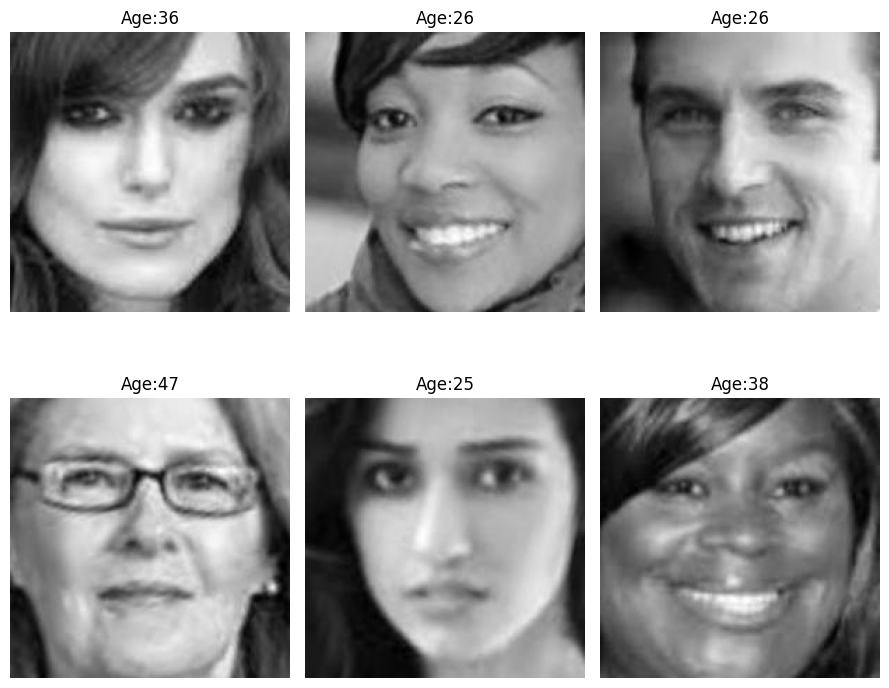

In [ ]:
rows = 2
cols = 3
figure = plt.figure(figsize=(cols*3,rows*4))
for i in range(1, cols*rows + 1):
    k = np.random.randint(0,len(df))
    figure.add_subplot(rows, cols, i)

    age = df.age[k]

    im = df.pixels[k]
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title(f'Age:{age}')

plt.tight_layout()
plt.show()

## Dataset Preprocessing

In [ ]:
# Normalization
df['pixels'] = df['pixels'].apply(lambda x: x/255)

In [ ]:
class UTKFaceDatasetReg(Dataset):
    """
    Dataset pour la régression de l'âge (CNN1).
    Retourne une image (1, 200, 200) et un âge réel (float).
    """
    def __init__(self, df):
        super().__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        age = row['age']
        im = row['pixels']
        im = np.reshape(im, (1, 200, 200))
        im = torch.tensor(im, dtype=torch.float32)

        age = torch.tensor(age, dtype=torch.float32).unsqueeze(0)  # Tenseur scalaire pour la régression
        return im, age

def build_datasets_cnn1(df, min_age=0, max_age=90):
    filtered = df[(df['age'] > min_age) & (df['age'] <= max_age)].reset_index(drop=True)
    train, test = train_test_split(filtered, test_size=0.1, random_state=0)
    return UTKFaceDatasetReg(train), UTKFaceDatasetReg(test)



In [ ]:
import torchvision.transforms as T
from PIL import Image
# Based on https://github.com/Ebimsv/Facial_Age_estimation_PyTorch/blob/main/custom_dataset_dataloader.py
# --------------------------- TRANSFORMS -------------------------------------
# Training pipeline
# Transformations pour CNN2
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.80, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15, fill=0),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

eval_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

class UTKFaceDatasetCls(Dataset):
    """
    Dataset pour la classification de l'âge (CNN2).
    Retourne une image (1, 224, 224) et une classe d'âge (int).
    """
    def __init__(self, df, num_classes, transform=None):
        super().__init__()
        self.df = df
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,i):
        row = self.df.iloc[i]
        age = row['age']
        img_np = row['pixels']

        if img_np.dtype != np.uint8:
            img_np = img_np.astype(np.uint8)
        img = Image.fromarray(img_np, mode='L')

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.as_tensor(img_np, dtype=torch.float32)[None] / 255.

        class_idx = int((age - 1) / (90 / self.num_classes))
        if class_idx >= self.num_classes:
            class_idx = self.num_classes - 1
        class_idx = torch.tensor(class_idx, dtype=torch.long)

        return img, class_idx

def build_datasets_cnn2(df, min_age=1, max_age=90, num_classes=30):
    filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age)].reset_index(drop=True)
    train, test = train_test_split(filtered, test_size=0.1, random_state=0)
    return UTKFaceDatasetCls(train, num_classes, transform=train_transform), UTKFaceDatasetCls(test, num_classes, transform=eval_transform)

# Models architecture




## CNN models


### CNN 1


In [ ]:
# Basic CNN to test full notebook. Source : https://www.datacamp.com/tutorial/pytorch-cnn-tutorial

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1(nn.Module):
    def __init__(self, in_channels, dim_hidden=256, dropout=0.1):
        """
        Convolutional Neural Network for real-valued age prediction.

        Parameters
        ----------
        in_channels : int
            Number of input image channels (e.g., 1 for grayscale images).
        dim_hidden : int
            Number of neurons in the fully connected layer.
        dropout : float
            Dropout rate to use before the final regression layer.
        """
        super(CNN1, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling: 200x200 → 100x100

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        # Downsampling again: 100x100 → 50x50

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer to produce real-valued age prediction
        self.fc1 = nn.Linear(16 * 50 * 50, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, 1)  # Output layer

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters
        ----------
        x : torch.Tensor
            Batch of input images with shape (batch_size, in_channels, H, W)

        Returns
        -------
        torch.Tensor
            Predicted age for each image in the batch, shape (batch_size, 1)
        """
        x = F.relu(self.conv1(x))  # Convolution 1 + ReLU activation
        x = self.pool(x)           # Pooling 1
        x = F.relu(self.conv2(x))  # Convolution 2 + ReLU activation
        x = self.pool(x)           # Pooling 2

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))    # Fully connected + ReLU
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Final output: predicted age
        return x.squeeze(1)  # Optionally remove final dimension for regression


### CNN 2


In [ ]:
# More complex CNN based on : https://www.kaggle.com/code/leeminwoo/pytorch-multilabelcnn

class CNN2(nn.Module) :
    def __init__(self,
                 age_classes: int,
                 hidden_dim: int,
                 dropout: float
                 ) :
        super(CNN2, self).__init__()
        '''
        '''
        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            #nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )

        self.dnnModel = nn.Sequential(
            nn.Linear(256, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        )

        self.age_classifier = nn.Linear(32, age_classes)
    def forward(self, x) :
        '''
        output = self.model.forward_features(x)
        age = self.age_classifier(output)
        '''
        output = self.cnnModel(x)
        output = output.view(output.size(0), -1)
        output = self.dnnModel(output)

        age = self.age_classifier(output)
        #print(age.shape)
        return age

# Training loop
This is a basic training loop code. It takes a big configuration dictionnary to avoid never ending arguments in the functions.
We use [Weights and Biases](https://wandb.ai/) to log the trainings.
It logs every training informations and model performances in the cloud.
You have to create an account to use it. Every accounts are free for individuals or research teams.

In [ ]:
def print_logs(dataset_type: str, logs: dict):
    # Pretty-print the training or evaluation metrics.
    desc = [f'{name}: {value:.2f}' for name, value in logs.items()]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def loss_batch(model: nn.Module, images, labels, config: dict) -> dict:
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    images, labels = images.to(device), labels.to(device)

    pred = model(images)


    if config.get('model_type') == 'CNN1':
        labels = labels.view(-1)  # [batch_size, 1] → [batch_size]

    metrics['loss'] = loss_fn(pred, labels)
    return metrics



def eval_model(model: nn.Module, dataloader: DataLoader, config: dict) -> dict:
    # Evaluate the model over the entire validation set.
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for source, target in dataloader:
            metrics = loss_batch(model, source, target, config)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs


def train_model(model: nn.Module, config: dict):
    # Main training loop.
    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset, val_loader.dataset
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']
    model_type = config.get('model_type', 'CNN_Regressor')

    # Enable early stopping only for CNN2 (classification model)
    early_stop = model_type == 'CNN2'
    patience = config.get('early_stop_patience', 6)
    min_delta = config.get('early_stop_delta', 0.0)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    columns = ['epoch']
    for mode in ['train', 'validation']:
        columns += [f'{mode} - {colname}' for colname in ['source', 'target', 'predicted', 'likelihood']]
    log_table = wandb.Table(columns=columns)

    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')

        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (source, target) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, target, config)
            loss = metrics['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)
                train_logs = {f'Train - {m}': v for m, v in logs.items()}
                wandb.log(train_logs)  # Upload to the WandB cloud
                logs = defaultdict(list)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            }

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        # -------------------- EARLY STOP logic -----------------------
        if early_stop:
            current_val_loss = logs['loss']
            improvement = best_val_loss - current_val_loss
            if improvement > min_delta:
                best_val_loss = current_val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping triggered after epoch {e+1} (no improvement in validation loss for {patience} epochs).")
                    break
        # -------------------------------------------------------------

        wandb.log({**train_logs, **val_logs})  # Upload logs to WandB

        # Prediction for a random train sample
        train_idx = torch.randint(len(train_dataset), (1,)).item()
        train_image, train_label = train_dataset[train_idx]
        train_image_device = train_image.unsqueeze(0).to(device)  # Add batch dimension
        model.eval()
        with torch.no_grad():
            train_pred = model(train_image_device)
            #train_pred_class = torch.argmax(train_pred, dim=1).item() # Comment if CNN1
            #train_likelihood = torch.softmax(train_pred, dim=1)[0][train_pred_class].item() # Comment if CNN1

        # Prediction for a random validation sample
        val_idx = torch.randint(len(val_dataset), (1,)).item()
        val_image, val_label = val_dataset[val_idx]
        val_image_device = val_image.unsqueeze(0).to(device)
        with torch.no_grad():
            val_pred = model(val_image_device)
            #val_pred_class = torch.argmax(val_pred, dim=1).item() # Comment if CNN1
            #val_likelihood = torch.softmax(val_pred, dim=1)[0][val_pred_class].item() # Comment if CNN1

        if model_type == 'CNN1':
            # Simple scalar output for regression
            print(f"CNN1 : Epoch {e+1} Train Prediction - Real age: {train_label.item()}, Predicted: {train_pred.item():.2f}")
            print(f"CNN1: Epoch {e+1} Val Prediction   - Real age: {val_label.item()}, Predicted: {val_pred.item():.2f}")
        else:
            # For CNN2: classification output → convert class to age estimate
            bin_width = 90 / config['num_classes']  # Define bin width

            # Convert class indices back to approximate age by taking the midpoint of each age bin.
            # The conversion formula is: age = 1 + (class_index + 0.5) * bin_width
            train_label_age = int(round(1 + (train_label.item() + 0.5) * bin_width))
            train_pred_age = int(round(1 + (train_pred_class + 0.5) * bin_width))
            val_label_age = int(round(1 + (val_label.item() + 0.5) * bin_width))
            val_pred_age = int(round(1 + (val_pred_class + 0.5) * bin_width))

            # Print classification results
            print(f"CNN2: Epoch {e+1} Train Prediction - Real age: {train_label_age}, Predicted: {train_pred_age}, Likelihood: {train_likelihood:.4f}")
            print(f"CNN2: Epoch {e+1} Val Prediction   - Real age: {val_label_age}, Predicted: {val_pred_age}, Likelihood: {val_likelihood:.4f}")

            # Log predictions to wandb table for qualitative analysis
            row_data = [
                e + 1,
                wandb.Image(train_image.squeeze(0).cpu().numpy()),
                train_label_age,
                train_pred_age,
                train_likelihood,
                wandb.Image(val_image.squeeze(0).cpu().numpy()),
                val_label_age,
                val_pred_age,
                val_likelihood
            ]
            log_table.add_data(*row_data)

    wandb.log({'Model predictions': log_table})  # Final wandb logging


# Training the models
We can now finally train the models.
Choose the right hyperparameters, play with them and try to find
ones that lead to good models and good training curves.
Try to reach a loss under 1.0.

---

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

In [ ]:
# Checking GPU and logging to wandb

!wandb login

!nvidia-smi

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moustaphang04 (moustaphang04-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Wed Apr 23 23:05:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usa

### Instanciation

In [ ]:
# Paramètres partagés
MIN_AGE = 1
MAX_AGE = 90
NUM_CLASSES = 30  # pour CNN2

# Instanciation pour CNN1 (régression)
train_dataset_cnn1, val_dataset_cnn1 = build_datasets_cnn1(df, min_age=MIN_AGE, max_age=MAX_AGE)

# Instanciation pour CNN2 (classification)
#train_dataset_cnn2, val_dataset_cnn2 = build_datasets_cnn2(df, min_age=MIN_AGE, max_age=MAX_AGE, num_classes=NUM_CLASSES)

# Affichage des tailles
print(f"CNN1 - Régression : {len(train_dataset_cnn1):,} train / {len(val_dataset_cnn1):,} val")
#print(f"CNN2 - Classification : {len(train_dataset_cnn2):,} train / {len(val_dataset_cnn2):,} val")


CNN2 - Classification : 21,256 train / 2,362 val


In [ ]:
from torchinfo import summary

# Configuration de base
config = {
    # Général
    'epochs': 50,
    'batch_size': 128,
    'lr': 1e-3,
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Paramètres modèle
    'dim_hidden': 256,
    'dropout': 0.1,
    'model_type': 'CNN1',  # Choisir 'CNN1' ou 'CNN2'

    # Autres
    'seed': 0,
    'log_every': 50,
    'in_channels': 1,  # pour CNN1
    'num_classes': 30,  # pour CNN2
}

# Initialisation du seed
torch.manual_seed(config['seed'])

# Chargement des bons datasets
#if config['model_type'] == 'CNN2':
config['train_loader'] = DataLoader(train_dataset_cnn1, batch_size=config['batch_size'], shuffle=True, num_workers=2)
config['val_loader'] = DataLoader(val_dataset_cnn1, batch_size=config['batch_size'], shuffle=True, num_workers=2)
#else:
#config['train_loader'] = DataLoader(train_dataset_cnn2, batch_size=config['batch_size'], shuffle=True, num_workers=2)
#config['val_loader'] = DataLoader(val_dataset_cnn2, batch_size=config['batch_size'], shuffle=True, num_workers=2)

# Initialisation du modèle
if config['model_type'] == 'CNN1':
    model = CNN1(config['in_channels'], config['dim_hidden'], config['dropout'])
    config['loss'] = nn.L1Loss()
else:
    model = CNN2(config['num_classes'], config['dim_hidden'], config['dropout'])
    config['loss'] = nn.CrossEntropyLoss()

# Optimiseur
config['optimizer'] = optim.Adam(model.parameters(), lr=config['lr'])

# Affichage résumé
summary(model, input_size=(1, 1, 200, 200) if config['model_type'] == 'CNN1' else (1, 1, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     [1, 30]                   --
├─Sequential: 1-1                        [1, 256, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         640
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─LeakyReLU: 2-3                    [1, 64, 224, 224]         --
│    └─Dropout2d: 2-4                    [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 113, 113]         --
│    └─Conv2d: 2-6                       [1, 128, 113, 113]        73,856
│    └─BatchNorm2d: 2-7                  [1, 128, 113, 113]        256
│    └─LeakyReLU: 2-8                    [1, 128, 113, 113]        --
│    └─MaxPool2d: 2-9                    [1, 128, 57, 57]          --
│    └─Conv2d: 2-10                      [1, 256, 57, 57]          295,168
│    └─BatchNorm2d: 2-11                 [1, 256, 57, 57]          512
│ 

## Grid search

### LR and Hidden dim

####CNN1

In [ ]:
import copy

# Paramètres fixes pour la grid search
config['epochs'] = 5
config['dropout'] = 0.1

lr_list = [0.1, 0.01, 0.001, 0.0005]
hidden_dims = [128, 256, 512, 1024]


# Boucle sur chaque combinaison (lr, dim_hidden)
for lr in lr_list:
    for hd in hidden_dims:
        run_cfg = copy.deepcopy(config)

        run_cfg['lr'] = lr
        run_cfg['dim_hidden'] = hd

        # Dataset et loss selon le type de modèle
        if run_cfg['model_type'] == 'CNN1':
            run_cfg['train_loader'] = DataLoader(train_dataset_cnn1, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            run_cfg['val_loader'] = DataLoader(val_dataset_cnn1, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            model = CNN1(run_cfg['in_channels'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['loss'] = nn.L1Loss()
        else:
            run_cfg['train_loader'] = DataLoader(train_dataset_cnn2, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            run_cfg['val_loader'] = DataLoader(val_dataset_cnn2, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            model = CNN2(run_cfg['num_classes'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['loss'] = nn.CrossEntropyLoss()

        # Optimiseur
        run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=run_cfg['lr'])

        #  Suivi avec wandb
        with wandb.init(
            config=run_cfg,
            project='GreedySaerch CNN1',
            group=f"{run_cfg['model_type']} - GridSearch LR/Hidden",
            name=f"{run_cfg['model_type']} - lr={run_cfg['lr']} - hd={run_cfg['dim_hidden']}",
            save_code=True,
        ):
            train_model(model, run_cfg)

        del model
        torch.cuda.empty_cache()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: moustaphang04 (moustaphang04-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 14.43
Eval -    loss: 13.92
CNN1 : Epoch 1 Train Prediction - Real age: 9.0, Predicted: 29.72
CNN1: Epoch 1 Val Prediction   - Real age: 62.0, Predicted: 29.72

Epoch 2
Train -   loss: 14.80
Eval -    loss: 13.98
CNN1 : Epoch 2 Train Prediction - Real age: 28.0, Predicted: 29.37
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 29.37

Epoch 3
Train -   loss: 13.67
Eval -    loss: 14.02
CNN1 : Epoch 3 Train Prediction - Real age: 17.0, Predicted: 31.52
CNN1: Epoch 3 Val Prediction   - Real age: 24.0, Predicted: 31.52

Epoch 4
Train -   loss: 14.50
Eval -    loss: 14.06
CNN1 : Epoch 4 Train Prediction - Real age: 15.0, Predicted: 28.25
CNN1: Epoch 4 Val Prediction   - Real age: 35.0, Predicted: 28.25

Epoch 5
Train -   loss: 15.16
Eval -    loss: 14.01
CNN1 : Epoch 5 Train Prediction - Real age: 68.0, Predicted: 30.05
CNN1: Epoch 5 Val Prediction   - Real age: 31.0, Predicted: 30.05


Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▁▄▆█▅
Train - loss,15.16177
Validation - loss,14.00898


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 14.26
Eval -    loss: 14.00
CNN1 : Epoch 1 Train Prediction - Real age: 50.0, Predicted: 31.69
CNN1: Epoch 1 Val Prediction   - Real age: 24.0, Predicted: 31.69

Epoch 2
Train -   loss: 14.51
Eval -    loss: 14.00
CNN1 : Epoch 2 Train Prediction - Real age: 61.0, Predicted: 31.10
CNN1: Epoch 2 Val Prediction   - Real age: 25.0, Predicted: 31.10

Epoch 3
Train -   loss: 14.60
Eval -    loss: 14.07
CNN1 : Epoch 3 Train Prediction - Real age: 7.0, Predicted: 28.53
CNN1: Epoch 3 Val Prediction   - Real age: 29.0, Predicted: 28.53

Epoch 4
Train -   loss: 14.13
Eval -    loss: 13.95
CNN1 : Epoch 4 Train Prediction - Real age: 25.0, Predicted: 29.88
CNN1: Epoch 4 Val Prediction   - Real age: 10.0, Predicted: 29.88

Epoch 5
Train -   loss: 14.37
Eval -    loss: 14.00
CNN1 : Epoch 5 Train Prediction - Real age: 49.0, Predicted: 30.98
CNN1: Epoch 5 Val Prediction   - Real age: 29.0, Predicted: 30.98


Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▄▄█▁▄
Train - loss,14.37393
Validation - loss,14.00469


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 15.59
Eval -    loss: 13.98
CNN1 : Epoch 1 Train Prediction - Real age: 45.0, Predicted: 30.93
CNN1: Epoch 1 Val Prediction   - Real age: 34.0, Predicted: 30.93

Epoch 2
Train -   loss: 14.58
Eval -    loss: 13.97
CNN1 : Epoch 2 Train Prediction - Real age: 26.0, Predicted: 29.68
CNN1: Epoch 2 Val Prediction   - Real age: 28.0, Predicted: 29.68

Epoch 3
Train -   loss: 14.32
Eval -    loss: 14.01
CNN1 : Epoch 3 Train Prediction - Real age: 39.0, Predicted: 31.20
CNN1: Epoch 3 Val Prediction   - Real age: 26.0, Predicted: 31.20

Epoch 4
Train -   loss: 13.48
Eval -    loss: 13.96
CNN1 : Epoch 4 Train Prediction - Real age: 27.0, Predicted: 29.24
CNN1: Epoch 4 Val Prediction   - Real age: 14.0, Predicted: 29.24

Epoch 5
Train -   loss: 14.30
Eval -    loss: 14.07
CNN1 : Epoch 5 Train Prediction - Real age: 49.0, Predicted: 31.69
CNN1: Epoch 5 Val Prediction   - Real age: 21.0, Predicted: 31.69


Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▂▂▄▁█
Train - loss,14.30082
Validation - loss,14.06976


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 14.30
Eval -    loss: 14.03
CNN1 : Epoch 1 Train Prediction - Real age: 28.0, Predicted: 29.19
CNN1: Epoch 1 Val Prediction   - Real age: 8.0, Predicted: 29.19

Epoch 2
Train -   loss: 15.32
Eval -    loss: 13.94
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 29.37
CNN1: Epoch 2 Val Prediction   - Real age: 35.0, Predicted: 29.37

Epoch 3
Train -   loss: 13.95
Eval -    loss: 14.00
CNN1 : Epoch 3 Train Prediction - Real age: 6.0, Predicted: 30.11
CNN1: Epoch 3 Val Prediction   - Real age: 4.0, Predicted: 30.11

Epoch 4
Train -   loss: 15.35
Eval -    loss: 14.05
CNN1 : Epoch 4 Train Prediction - Real age: 32.0, Predicted: 28.45
CNN1: Epoch 4 Val Prediction   - Real age: 26.0, Predicted: 28.45

Epoch 5
Train -   loss: 14.61
Eval -    loss: 14.12
CNN1 : Epoch 5 Train Prediction - Real age: 56.0, Predicted: 31.69
CNN1: Epoch 5 Val Prediction   - Real age: 18.0, Predicted: 31.69


Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▅▁▄▆█
Train - loss,14.60787
Validation - loss,14.11594


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.83
Eval -    loss: 15.60
CNN1 : Epoch 1 Train Prediction - Real age: 54.0, Predicted: 37.26
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 38.51

Epoch 2
Train -   loss: 14.32
Eval -    loss: 18.62
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 46.00
CNN1: Epoch 2 Val Prediction   - Real age: 25.0, Predicted: 33.20

Epoch 3
Train -   loss: 11.05
Eval -    loss: 12.36
CNN1 : Epoch 3 Train Prediction - Real age: 21.0, Predicted: 25.80
CNN1: Epoch 3 Val Prediction   - Real age: 27.0, Predicted: 22.06

Epoch 4
Train -   loss: 11.61
Eval -    loss: 10.26
CNN1 : Epoch 4 Train Prediction - Real age: 28.0, Predicted: 28.30
CNN1: Epoch 4 Val Prediction   - Real age: 34.0, Predicted: 36.77

Epoch 5
Train -   loss: 10.06
Eval -    loss: 9.55
CNN1 : Epoch 5 Train Prediction - Real age: 50.0, Predicted: 49.23
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 43.82


Train - loss,█▅▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▂▁▁▁▁▁▁▁
Validation - loss,▆█▃▂▁
Train - loss,10.06107
Validation - loss,9.54842


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 13.68
Eval -    loss: 14.38
CNN1 : Epoch 1 Train Prediction - Real age: 44.0, Predicted: 36.93
CNN1: Epoch 1 Val Prediction   - Real age: 36.0, Predicted: 31.58

Epoch 2
Train -   loss: 11.28
Eval -    loss: 11.84
CNN1 : Epoch 2 Train Prediction - Real age: 55.0, Predicted: 28.57
CNN1: Epoch 2 Val Prediction   - Real age: 59.0, Predicted: 24.15

Epoch 3
Train -   loss: 10.10
Eval -    loss: 11.14
CNN1 : Epoch 3 Train Prediction - Real age: 38.0, Predicted: 43.64
CNN1: Epoch 3 Val Prediction   - Real age: 48.0, Predicted: 40.14

Epoch 4
Train -   loss: 12.83
Eval -    loss: 10.56
CNN1 : Epoch 4 Train Prediction - Real age: 53.0, Predicted: 41.19
CNN1: Epoch 4 Val Prediction   - Real age: 30.0, Predicted: 21.90

Epoch 5
Train -   loss: 10.10
Eval -    loss: 9.63
CNN1 : Epoch 5 Train Prediction - Real age: 40.0, Predicted: 40.69
CNN1: Epoch 5 Val Prediction   - Real age: 59.0, Predicted: 60.10


Train - loss,█▄▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁
Validation - loss,█▄▃▂▁
Train - loss,10.09835
Validation - loss,9.62865


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 13.30
Eval -    loss: 13.77
CNN1 : Epoch 1 Train Prediction - Real age: 4.0, Predicted: 11.74
CNN1: Epoch 1 Val Prediction   - Real age: 4.0, Predicted: 15.53

Epoch 2
Train -   loss: 12.11
Eval -    loss: 16.08
CNN1 : Epoch 2 Train Prediction - Real age: 25.0, Predicted: 42.82
CNN1: Epoch 2 Val Prediction   - Real age: 29.0, Predicted: 48.81

Epoch 3
Train -   loss: 10.71
Eval -    loss: 11.82
CNN1 : Epoch 3 Train Prediction - Real age: 58.0, Predicted: 57.56
CNN1: Epoch 3 Val Prediction   - Real age: 39.0, Predicted: 49.95

Epoch 4
Train -   loss: 10.82
Eval -    loss: 10.17
CNN1 : Epoch 4 Train Prediction - Real age: 26.0, Predicted: 18.25
CNN1: Epoch 4 Val Prediction   - Real age: 26.0, Predicted: 32.46

Epoch 5
Train -   loss: 9.25
Eval -    loss: 8.97
CNN1 : Epoch 5 Train Prediction - Real age: 63.0, Predicted: 67.15
CNN1: Epoch 5 Val Prediction   - Real age: 50.0, Predicted: 39.51


Train - loss,█▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▂▁▁▁▂▁▁▁▁
Validation - loss,▆█▄▂▁
Train - loss,9.25429
Validation - loss,8.96536


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 14.04
Eval -    loss: 12.81
CNN1 : Epoch 1 Train Prediction - Real age: 25.0, Predicted: 36.10
CNN1: Epoch 1 Val Prediction   - Real age: 36.0, Predicted: 36.33

Epoch 2
Train -   loss: 12.59
Eval -    loss: 15.08
CNN1 : Epoch 2 Train Prediction - Real age: 76.0, Predicted: 47.63
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 37.49

Epoch 3
Train -   loss: 10.45
Eval -    loss: 10.10
CNN1 : Epoch 3 Train Prediction - Real age: 70.0, Predicted: 56.85
CNN1: Epoch 3 Val Prediction   - Real age: 28.0, Predicted: 32.40

Epoch 4
Train -   loss: 9.76
Eval -    loss: 9.41
CNN1 : Epoch 4 Train Prediction - Real age: 22.0, Predicted: 23.66
CNN1: Epoch 4 Val Prediction   - Real age: 25.0, Predicted: 29.79

Epoch 5
Train -   loss: 9.47
Eval -    loss: 9.35
CNN1 : Epoch 5 Train Prediction - Real age: 32.0, Predicted: 26.90
CNN1: Epoch 5 Val Prediction   - Real age: 31.0, Predicted: 23.48


Train - loss,█▄▃▃▃▂▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Validation - loss,▅█▂▁▁
Train - loss,9.46667
Validation - loss,9.3525


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 10.93
Eval -    loss: 11.43
CNN1 : Epoch 1 Train Prediction - Real age: 60.0, Predicted: 26.46
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 38.37

Epoch 2
Train -   loss: 10.47
Eval -    loss: 10.83
CNN1 : Epoch 2 Train Prediction - Real age: 13.0, Predicted: 23.23
CNN1: Epoch 2 Val Prediction   - Real age: 27.0, Predicted: 38.11

Epoch 3
Train -   loss: 9.60
Eval -    loss: 9.43
CNN1 : Epoch 3 Train Prediction - Real age: 26.0, Predicted: 28.44
CNN1: Epoch 3 Val Prediction   - Real age: 80.0, Predicted: 63.54

Epoch 4
Train -   loss: 9.19
Eval -    loss: 8.90
CNN1 : Epoch 4 Train Prediction - Real age: 4.0, Predicted: 17.96
CNN1: Epoch 4 Val Prediction   - Real age: 2.0, Predicted: 6.56

Epoch 5
Train -   loss: 9.73
Eval -    loss: 8.69
CNN1 : Epoch 5 Train Prediction - Real age: 4.0, Predicted: 21.13
CNN1: Epoch 5 Val Prediction   - Real age: 30.0, Predicted: 36.53


Train - loss,█▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▆▃▂▁
Train - loss,9.73429
Validation - loss,8.69482


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.62
Eval -    loss: 11.99
CNN1 : Epoch 1 Train Prediction - Real age: 25.0, Predicted: 27.74
CNN1: Epoch 1 Val Prediction   - Real age: 30.0, Predicted: 25.50

Epoch 2
Train -   loss: 10.71
Eval -    loss: 10.50
CNN1 : Epoch 2 Train Prediction - Real age: 26.0, Predicted: 34.44
CNN1: Epoch 2 Val Prediction   - Real age: 78.0, Predicted: 53.93

Epoch 3
Train -   loss: 10.21
Eval -    loss: 9.58
CNN1 : Epoch 3 Train Prediction - Real age: 64.0, Predicted: 42.63
CNN1: Epoch 3 Val Prediction   - Real age: 70.0, Predicted: 45.81

Epoch 4
Train -   loss: 9.65
Eval -    loss: 9.06
CNN1 : Epoch 4 Train Prediction - Real age: 4.0, Predicted: 22.25
CNN1: Epoch 4 Val Prediction   - Real age: 26.0, Predicted: 24.18

Epoch 5
Train -   loss: 8.86
Eval -    loss: 9.06
CNN1 : Epoch 5 Train Prediction - Real age: 35.0, Predicted: 26.04
CNN1: Epoch 5 Val Prediction   - Real age: 56.0, Predicted: 30.40


Train - loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▂▁▁
Train - loss,8.86217
Validation - loss,9.05732


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.64
Eval -    loss: 12.35
CNN1 : Epoch 1 Train Prediction - Real age: 82.0, Predicted: 43.29
CNN1: Epoch 1 Val Prediction   - Real age: 27.0, Predicted: 35.72

Epoch 2
Train -   loss: 10.26
Eval -    loss: 10.67
CNN1 : Epoch 2 Train Prediction - Real age: 19.0, Predicted: 27.33
CNN1: Epoch 2 Val Prediction   - Real age: 33.0, Predicted: 51.76

Epoch 3
Train -   loss: 10.13
Eval -    loss: 9.51
CNN1 : Epoch 3 Train Prediction - Real age: 26.0, Predicted: 28.25
CNN1: Epoch 3 Val Prediction   - Real age: 36.0, Predicted: 32.13

Epoch 4
Train -   loss: 9.39
Eval -    loss: 9.03
CNN1 : Epoch 4 Train Prediction - Real age: 30.0, Predicted: 39.96
CNN1: Epoch 4 Val Prediction   - Real age: 2.0, Predicted: 10.32

Epoch 5
Train -   loss: 8.99
Eval -    loss: 8.57
CNN1 : Epoch 5 Train Prediction - Real age: 9.0, Predicted: 27.79
CNN1: Epoch 5 Val Prediction   - Real age: 2.0, Predicted: 10.08


Train - loss,█▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▃▂▁
Train - loss,8.9917
Validation - loss,8.56561


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.93
Eval -    loss: 12.90
CNN1 : Epoch 1 Train Prediction - Real age: 52.0, Predicted: 29.03
CNN1: Epoch 1 Val Prediction   - Real age: 45.0, Predicted: 37.21

Epoch 2
Train -   loss: 10.62
Eval -    loss: 10.96
CNN1 : Epoch 2 Train Prediction - Real age: 58.0, Predicted: 40.79
CNN1: Epoch 2 Val Prediction   - Real age: 6.0, Predicted: 13.85

Epoch 3
Train -   loss: 10.75
Eval -    loss: 10.52
CNN1 : Epoch 3 Train Prediction - Real age: 26.0, Predicted: 31.08
CNN1: Epoch 3 Val Prediction   - Real age: 56.0, Predicted: 69.50

Epoch 4
Train -   loss: 9.60
Eval -    loss: 9.35
CNN1 : Epoch 4 Train Prediction - Real age: 88.0, Predicted: 58.52
CNN1: Epoch 4 Val Prediction   - Real age: 33.0, Predicted: 27.04

Epoch 5
Train -   loss: 9.36
Eval -    loss: 8.95
CNN1 : Epoch 5 Train Prediction - Real age: 80.0, Predicted: 51.18
CNN1: Epoch 5 Val Prediction   - Real age: 35.0, Predicted: 24.73


Train - loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▄▂▁
Train - loss,9.35532
Validation - loss,8.95419


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.32
Eval -    loss: 12.24
CNN1 : Epoch 1 Train Prediction - Real age: 26.0, Predicted: 35.96
CNN1: Epoch 1 Val Prediction   - Real age: 54.0, Predicted: 32.06

Epoch 2
Train -   loss: 11.10
Eval -    loss: 11.34
CNN1 : Epoch 2 Train Prediction - Real age: 32.0, Predicted: 37.67
CNN1: Epoch 2 Val Prediction   - Real age: 16.0, Predicted: 21.36

Epoch 3
Train -   loss: 11.45
Eval -    loss: 10.73
CNN1 : Epoch 3 Train Prediction - Real age: 32.0, Predicted: 32.93
CNN1: Epoch 3 Val Prediction   - Real age: 60.0, Predicted: 35.12

Epoch 4
Train -   loss: 10.83
Eval -    loss: 11.43
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 35.17
CNN1: Epoch 4 Val Prediction   - Real age: 3.0, Predicted: 47.58

Epoch 5
Train -   loss: 10.07
Eval -    loss: 10.23
CNN1 : Epoch 5 Train Prediction - Real age: 43.0, Predicted: 30.78
CNN1: Epoch 5 Val Prediction   - Real age: 35.0, Predicted: 29.94


Train - loss,█▃▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Validation - loss,█▅▃▅▁
Train - loss,10.06525
Validation - loss,10.22728


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.97
Eval -    loss: 12.67
CNN1 : Epoch 1 Train Prediction - Real age: 22.0, Predicted: 32.63
CNN1: Epoch 1 Val Prediction   - Real age: 39.0, Predicted: 42.83

Epoch 2
Train -   loss: 11.30
Eval -    loss: 11.18
CNN1 : Epoch 2 Train Prediction - Real age: 60.0, Predicted: 71.16
CNN1: Epoch 2 Val Prediction   - Real age: 36.0, Predicted: 45.56

Epoch 3
Train -   loss: 11.51
Eval -    loss: 11.37
CNN1 : Epoch 3 Train Prediction - Real age: 30.0, Predicted: 18.86
CNN1: Epoch 3 Val Prediction   - Real age: 36.0, Predicted: 15.31

Epoch 4
Train -   loss: 9.93
Eval -    loss: 10.37
CNN1 : Epoch 4 Train Prediction - Real age: 26.0, Predicted: 33.93
CNN1: Epoch 4 Val Prediction   - Real age: 26.0, Predicted: 28.88

Epoch 5
Train -   loss: 9.79
Eval -    loss: 9.58
CNN1 : Epoch 5 Train Prediction - Real age: 90.0, Predicted: 27.32
CNN1: Epoch 5 Val Prediction   - Real age: 36.0, Predicted: 35.12


Train - loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▅▃▁
Train - loss,9.79441
Validation - loss,9.58452


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.40
Eval -    loss: 11.64
CNN1 : Epoch 1 Train Prediction - Real age: 5.0, Predicted: 24.34
CNN1: Epoch 1 Val Prediction   - Real age: 25.0, Predicted: 28.23

Epoch 2
Train -   loss: 10.86
Eval -    loss: 11.01
CNN1 : Epoch 2 Train Prediction - Real age: 26.0, Predicted: 44.98
CNN1: Epoch 2 Val Prediction   - Real age: 20.0, Predicted: 22.65

Epoch 3
Train -   loss: 10.39
Eval -    loss: 9.55
CNN1 : Epoch 3 Train Prediction - Real age: 39.0, Predicted: 45.48
CNN1: Epoch 3 Val Prediction   - Real age: 33.0, Predicted: 48.25

Epoch 4
Train -   loss: 9.09
Eval -    loss: 8.98
CNN1 : Epoch 4 Train Prediction - Real age: 62.0, Predicted: 45.57
CNN1: Epoch 4 Val Prediction   - Real age: 48.0, Predicted: 18.78

Epoch 5
Train -   loss: 9.63
Eval -    loss: 10.18
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 27.18
CNN1: Epoch 5 Val Prediction   - Real age: 67.0, Predicted: 61.70


Train - loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▆▃▁▄
Train - loss,9.62653
Validation - loss,10.18067


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.81
Eval -    loss: 12.30
CNN1 : Epoch 1 Train Prediction - Real age: 32.0, Predicted: 34.46
CNN1: Epoch 1 Val Prediction   - Real age: 75.0, Predicted: 44.58

Epoch 2
Train -   loss: 11.09
Eval -    loss: 11.12
CNN1 : Epoch 2 Train Prediction - Real age: 24.0, Predicted: 25.41
CNN1: Epoch 2 Val Prediction   - Real age: 40.0, Predicted: 35.39

Epoch 3
Train -   loss: 10.71
Eval -    loss: 9.98
CNN1 : Epoch 3 Train Prediction - Real age: 30.0, Predicted: 25.70
CNN1: Epoch 3 Val Prediction   - Real age: 57.0, Predicted: 35.13

Epoch 4
Train -   loss: 9.10
Eval -    loss: 9.09
CNN1 : Epoch 4 Train Prediction - Real age: 46.0, Predicted: 28.04
CNN1: Epoch 4 Val Prediction   - Real age: 40.0, Predicted: 36.77

Epoch 5
Train -   loss: 9.25
Eval -    loss: 9.62
CNN1 : Epoch 5 Train Prediction - Real age: 35.0, Predicted: 21.68
CNN1: Epoch 5 Val Prediction   - Real age: 34.0, Predicted: 33.90


Train - loss,█▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Validation - loss,█▅▃▁▂
Train - loss,9.25233
Validation - loss,9.62278


##### Resultats

| Learning Rate | Hidden Dim | Train Loss | Val Loss |
|---------------|------------|------------|----------|
| 0.1           | 128        | 15.16      | 14.01    |
| 0.1           | 256        | 14.37      | 14.00    |
| 0.1           | 512        | 14.30      | 14.07    |
| 0.1           | 1024       | 14.61      | 14.12    |
| 0.01          | 128        | 10.06      | 9.55     |
| 0.01          | 256        | 10.10      | 9.63     |
| 0.01          | 512        | 9.25       | 8.97     |
| 0.01          | 1024       | 9.47       | 9.35     |
| 0.001         | 128        | 9.73       | 8.69     |
| 0.001         | 256        | 8.86       | 9.06     |
| 0.001         | 512        | 8.99       | 8.57     |
| 0.001         | 1024       | 9.36       | 8.95     |
| 0.0005        | 128        | 10.07      | 10.23    |
| 0.0005        | 256        | 9.79       | 9.58     |
| 0.0005        | 512        | 9.63       | 10.18    |
| 0.0005        | 1024       | 9.25       | 9.62     |


Parmi toutes les combinaisons testées pour le modèle CNN1, la meilleure performance a été obtenue avec un taux d’apprentissage de 0.001 et une dimension cachée (hidden_dim) de 512, atteignant une perte de validation minimale de 8.57 et une perte d'entraînement de 8.99 après 5 époques. Ces résultats suggèrent que cette configuration offre le meilleur compromis entre capacité d’apprentissage et généralisation.

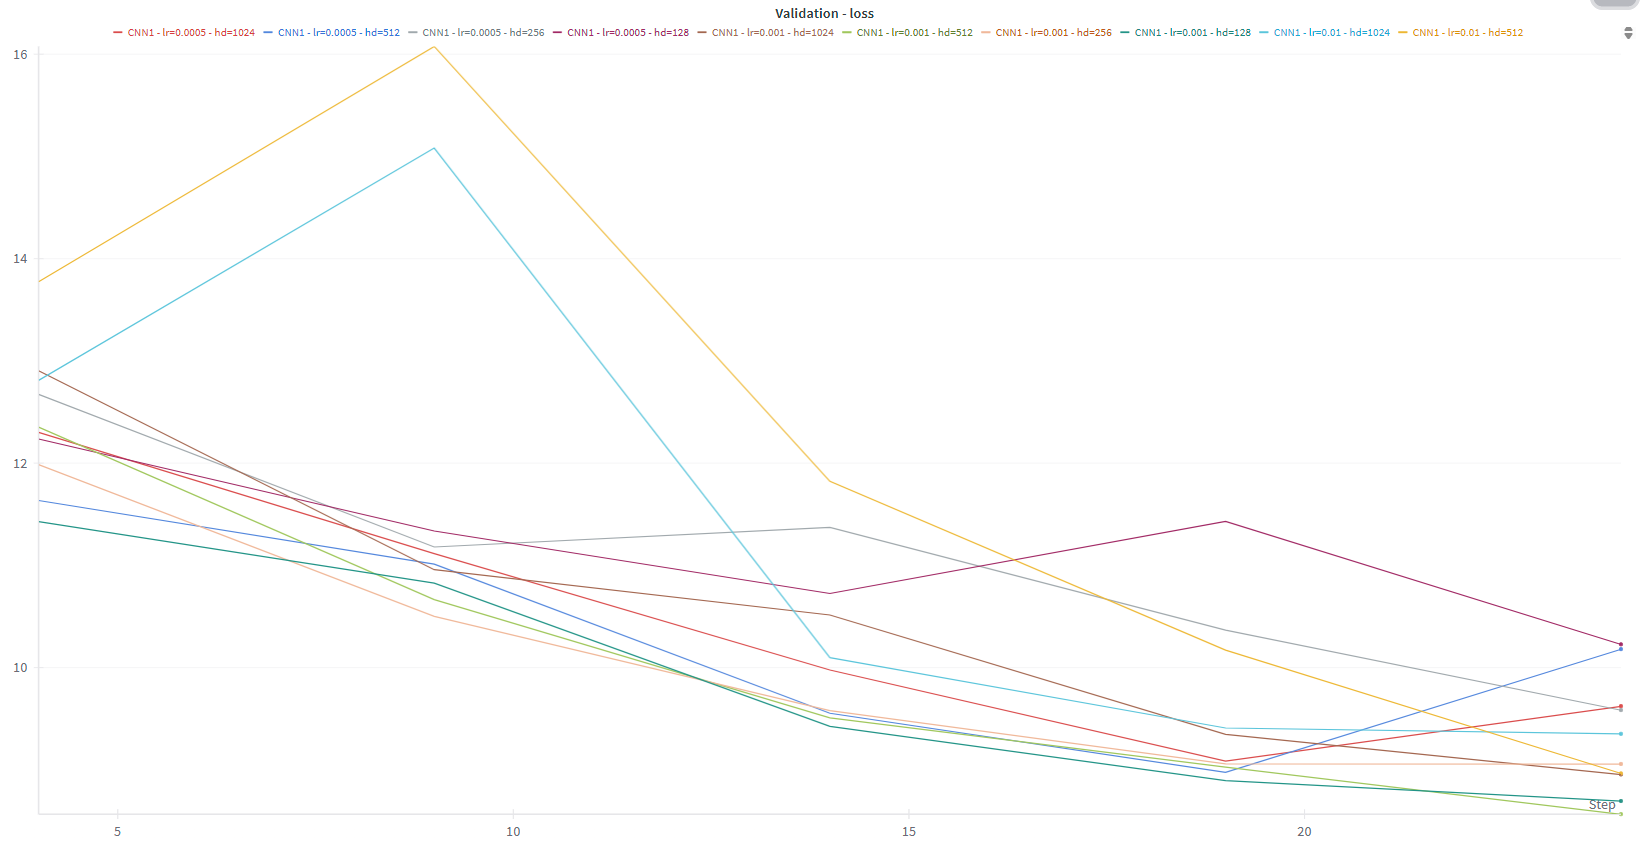

####CNN2

In [ ]:
import copy

# Paramètres fixes pour la grid search
config['epochs'] = 5
config['dropout'] = 0.1

lr_list = [0.1, 0.01, 0.001, 0.0005]
hidden_dims = [128, 256, 512, 1024]


# Boucle sur chaque combinaison (lr, dim_hidden)
for lr in lr_list:
    for hd in hidden_dims:
        run_cfg = copy.deepcopy(config)

        run_cfg['lr'] = lr
        run_cfg['dim_hidden'] = hd

        # Dataset et loss selon le type de modèle
        if run_cfg['model_type'] == 'CNN1':
            run_cfg['train_loader'] = DataLoader(train_dataset_cnn1, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            run_cfg['val_loader'] = DataLoader(val_dataset_cnn1, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            model = CNN1(run_cfg['in_channels'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['loss'] = nn.L1Loss()
        else:
            run_cfg['train_loader'] = DataLoader(train_dataset_cnn2, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            run_cfg['val_loader'] = DataLoader(val_dataset_cnn2, batch_size=run_cfg['batch_size'], shuffle=True, num_workers=2)
            model = CNN2(run_cfg['num_classes'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['loss'] = nn.CrossEntropyLoss()

        # Optimiseur
        run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=run_cfg['lr'])

        #  Suivi avec wandb
        with wandb.init(
            config=run_cfg,
            project='CNN2 Greedy search',
            group=f"{run_cfg['model_type']} - GridSearch LR/Hidden",
            name=f"{run_cfg['model_type']} - lr={run_cfg['lr']} - hd={run_cfg['dim_hidden']}",
            save_code=True,
        ):
            train_model(model, run_cfg)

        del model
        torch.cuda.empty_cache()


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.04
Eval -    loss: 3.02
CNN2: Epoch 1 Train Prediction - Real age: 38, Predicted: 26, Likelihood: 0.1701
CNN2: Epoch 1 Val Prediction   - Real age: 54, Predicted: 2, Likelihood: 0.2016

Epoch 2
Train -   loss: 2.99
Eval -    loss: 3.28
CNN2: Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1482
CNN2: Epoch 2 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.4046

Epoch 3
Train -   loss: 3.17
Eval -    loss: 3.08
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 30, Likelihood: 0.1321
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 2, Likelihood: 0.1469

Epoch 4
Train -   loss: 3.14
Eval -    loss: 3.06
CNN2: Epoch 4 Train Prediction - Real age: 18, Predicted: 26, Likelihood: 0.1632
CNN2: Epoch 4 Val Prediction   - Real age: 2, Predicted: 26, Likelihood: 0.2219

Epoch 5
Train -   loss: 3.05
Eval -    loss: 3.14
CNN2: Epoch 5 Train Prediction - Real age: 30, Predicted:

Train - loss,▃█▁▁▁▁▁▁▁▁▁▁▃▃▂▂▂▂▂▂▁▂▁▁▁
Validation - loss,▁█▃▂▄
Train - loss,3.04791
Validation - loss,3.14089


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.16
Eval -    loss: 3.08
CNN2: Epoch 1 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.1214
CNN2: Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1528

Epoch 2
Train -   loss: 3.23
Eval -    loss: 3.02
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.2291
CNN2: Epoch 2 Val Prediction   - Real age: 30, Predicted: 26, Likelihood: 0.1685

Epoch 3
Train -   loss: 3.26
Eval -    loss: 3.15
CNN2: Epoch 3 Train Prediction - Real age: 24, Predicted: 20, Likelihood: 0.1651
CNN2: Epoch 3 Val Prediction   - Real age: 18, Predicted: 20, Likelihood: 0.1233

Epoch 4
Train -   loss: 4.39
Eval -    loss: 3.32
CNN2: Epoch 4 Train Prediction - Real age: 44, Predicted: 30, Likelihood: 0.2136
CNN2: Epoch 4 Val Prediction   - Real age: 72, Predicted: 2, Likelihood: 0.2134

Epoch 5
Train -   loss: 3.05
Eval -    loss: 3.07
CNN2: Epoch 5 Train Prediction - Real age: 6, Predicte

Train - loss,▂█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▄▁▁▁▁▁
Validation - loss,▂▁▄█▂
Train - loss,3.0533
Validation - loss,3.06852


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.08
Eval -    loss: 3.33
CNN2: Epoch 1 Train Prediction - Real age: 2, Predicted: 26, Likelihood: 0.1521
CNN2: Epoch 1 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1369

Epoch 2
Train -   loss: 3.12
Eval -    loss: 3.05
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1291
CNN2: Epoch 2 Val Prediction   - Real age: 30, Predicted: 26, Likelihood: 0.1276

Epoch 3
Train -   loss: 3.27
Eval -    loss: 3.37
CNN2: Epoch 3 Train Prediction - Real age: 26, Predicted: 72, Likelihood: 0.1488
CNN2: Epoch 3 Val Prediction   - Real age: 86, Predicted: 26, Likelihood: 0.1085

Epoch 4
Train -   loss: 3.26
Eval -    loss: 3.17
CNN2: Epoch 4 Train Prediction - Real age: 48, Predicted: 44, Likelihood: 0.1183
CNN2: Epoch 4 Val Prediction   - Real age: 2, Predicted: 44, Likelihood: 0.1144

Epoch 5
Train -   loss: 3.12
Eval -    loss: 3.13
CNN2: Epoch 5 Train Prediction - Real age: 36, Predicte

Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▇▁█▃▃
Train - loss,3.12215
Validation - loss,3.12716


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.21
Eval -    loss: 3.46
CNN2: Epoch 1 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2096
CNN2: Epoch 1 Val Prediction   - Real age: 54, Predicted: 26, Likelihood: 0.2199

Epoch 2
Train -   loss: 3.20
Eval -    loss: 3.30
CNN2: Epoch 2 Train Prediction - Real age: 54, Predicted: 26, Likelihood: 0.3962
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2873

Epoch 3
Train -   loss: 3.14
Eval -    loss: 3.11
CNN2: Epoch 3 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2032
CNN2: Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1947

Epoch 4
Train -   loss: 3.12
Eval -    loss: 3.10
CNN2: Epoch 4 Train Prediction - Real age: 42, Predicted: 30, Likelihood: 0.1951
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 30, Likelihood: 0.1319

Epoch 5
Train -   loss: 3.15
Eval -    loss: 3.05
CNN2: Epoch 5 Train Prediction - Real age: 66, Predict

Train - loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▂▂▁
Train - loss,3.14506
Validation - loss,3.05181


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.98
Eval -    loss: 2.98
CNN2: Epoch 1 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.2288
CNN2: Epoch 1 Val Prediction   - Real age: 38, Predicted: 2, Likelihood: 0.2329

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.93
CNN2: Epoch 2 Train Prediction - Real age: 86, Predicted: 60, Likelihood: 0.0917
CNN2: Epoch 2 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1671

Epoch 3
Train -   loss: 2.80
Eval -    loss: 2.86
CNN2: Epoch 3 Train Prediction - Real age: 56, Predicted: 36, Likelihood: 0.0791
CNN2: Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2101

Epoch 4
Train -   loss: 2.78
Eval -    loss: 2.88
CNN2: Epoch 4 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1574
CNN2: Epoch 4 Val Prediction   - Real age: 26, Predicted: 2, Likelihood: 0.1929

Epoch 5
Train -   loss: 2.74
Eval -    loss: 2.81
CNN2: Epoch 5 Train Prediction - Real age: 32, Predicte

Train - loss,█▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Validation - loss,█▆▃▄▁
Train - loss,2.73549
Validation - loss,2.81147


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.91
Eval -    loss: 3.03
CNN2: Epoch 1 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1891
CNN2: Epoch 1 Val Prediction   - Real age: 30, Predicted: 26, Likelihood: 0.2413

Epoch 2
Train -   loss: 2.87
Eval -    loss: 2.93
CNN2: Epoch 2 Train Prediction - Real age: 26, Predicted: 2, Likelihood: 0.1466
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 2, Likelihood: 0.1245

Epoch 3
Train -   loss: 2.83
Eval -    loss: 2.80
CNN2: Epoch 3 Train Prediction - Real age: 72, Predicted: 26, Likelihood: 0.0833
CNN2: Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.3756

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.90
CNN2: Epoch 4 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.4746
CNN2: Epoch 4 Val Prediction   - Real age: 66, Predicted: 26, Likelihood: 0.1100

Epoch 5
Train -   loss: 2.74
Eval -    loss: 2.78
CNN2: Epoch 5 Train Prediction - Real age: 26, Predicted: 2

Train - loss,█▅▄▄▃▄▃▃▃▂▄▃▂▂▂▁▂▂▂▁▄▂▁▁▁
Validation - loss,█▅▂▄▁
Train - loss,2.74191
Validation - loss,2.77668


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.99
Eval -    loss: 2.98
CNN2: Epoch 1 Train Prediction - Real age: 84, Predicted: 26, Likelihood: 0.0844
CNN2: Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1786

Epoch 2
Train -   loss: 2.89
Eval -    loss: 3.09
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.2935
CNN2: Epoch 2 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.9071

Epoch 3
Train -   loss: 2.82
Eval -    loss: 2.87
CNN2: Epoch 3 Train Prediction - Real age: 12, Predicted: 26, Likelihood: 0.1906
CNN2: Epoch 3 Val Prediction   - Real age: 8, Predicted: 26, Likelihood: 0.2363

Epoch 4
Train -   loss: 2.83
Eval -    loss: 2.83
CNN2: Epoch 4 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1045
CNN2: Epoch 4 Val Prediction   - Real age: 26, Predicted: 2, Likelihood: 0.2309

Epoch 5
Train -   loss: 2.79
Eval -    loss: 2.74
CNN2: Epoch 5 Train Prediction - Real age: 66, Predicted:

Train - loss,█▄▃▃▃▃▃▃▃▂▂▃▃▂▁▁▂▂▁▂▂▂▁▁▁
Validation - loss,▆█▄▃▁
Train - loss,2.78636
Validation - loss,2.74039


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.95
Eval -    loss: 2.97
CNN2: Epoch 1 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1416
CNN2: Epoch 1 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1088

Epoch 2
Train -   loss: 2.89
Eval -    loss: 2.94
CNN2: Epoch 2 Train Prediction - Real age: 80, Predicted: 2, Likelihood: 0.6114
CNN2: Epoch 2 Val Prediction   - Real age: 6, Predicted: 2, Likelihood: 0.3143

Epoch 3
Train -   loss: 2.90
Eval -    loss: 2.94
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.0949
CNN2: Epoch 3 Val Prediction   - Real age: 74, Predicted: 36, Likelihood: 0.0938

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.73
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1914
CNN2: Epoch 4 Val Prediction   - Real age: 2, Predicted: 26, Likelihood: 0.1821

Epoch 5
Train -   loss: 2.74
Eval -    loss: 2.77
CNN2: Epoch 5 Train Prediction - Real age: 24, Predicted: 2

Train - loss,█▅▄▄▃▄▃▃▃▃▄▃▂▂▃▄▂▂▂▁▁▁▁▂▁
Validation - loss,█▇▇▁▂
Train - loss,2.73936
Validation - loss,2.77411


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.98
Eval -    loss: 3.01
CNN2: Epoch 1 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1730
CNN2: Epoch 1 Val Prediction   - Real age: 50, Predicted: 2, Likelihood: 0.2259

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.92
CNN2: Epoch 2 Train Prediction - Real age: 24, Predicted: 26, Likelihood: 0.1353
CNN2: Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.1276

Epoch 3
Train -   loss: 2.86
Eval -    loss: 2.78
CNN2: Epoch 3 Train Prediction - Real age: 12, Predicted: 26, Likelihood: 0.1694
CNN2: Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1269

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.76
CNN2: Epoch 4 Train Prediction - Real age: 60, Predicted: 26, Likelihood: 0.0979
CNN2: Epoch 4 Val Prediction   - Real age: 12, Predicted: 2, Likelihood: 0.1605

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.76
CNN2: Epoch 5 Train Prediction - Real age: 36, Predicted

Train - loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Validation - loss,█▅▁▁▁
Train - loss,2.76463
Validation - loss,2.75753


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.01
Eval -    loss: 2.94
CNN2: Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2134
CNN2: Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1423

Epoch 2
Train -   loss: 2.90
Eval -    loss: 3.02
CNN2: Epoch 2 Train Prediction - Real age: 26, Predicted: 2, Likelihood: 0.3957
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2788

Epoch 3
Train -   loss: 2.83
Eval -    loss: 2.81
CNN2: Epoch 3 Train Prediction - Real age: 24, Predicted: 26, Likelihood: 0.1108
CNN2: Epoch 3 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1904

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.80
CNN2: Epoch 4 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.2266
CNN2: Epoch 4 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2347

Epoch 5
Train -   loss: 2.72
Eval -    loss: 2.77
CNN2: Epoch 5 Train Prediction - Real age: 56, Predict

Train - loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▄▂▂▂▁▁▁▁▁▁
Validation - loss,▆█▂▂▁
Train - loss,2.72056
Validation - loss,2.76765


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.99
CNN2: Epoch 1 Train Prediction - Real age: 54, Predicted: 26, Likelihood: 0.1511
CNN2: Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1011

Epoch 2
Train -   loss: 2.89
Eval -    loss: 2.89
CNN2: Epoch 2 Train Prediction - Real age: 18, Predicted: 26, Likelihood: 0.1974
CNN2: Epoch 2 Val Prediction   - Real age: 32, Predicted: 2, Likelihood: 0.4614

Epoch 3
Train -   loss: 2.84
Eval -    loss: 2.81
CNN2: Epoch 3 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1182
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1794

Epoch 4
Train -   loss: 2.69
Eval -    loss: 2.74
CNN2: Epoch 4 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.2619
CNN2: Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.8877

Epoch 5
Train -   loss: 2.69
Eval -    loss: 2.71
CNN2: Epoch 5 Train Prediction - Real age: 30, Predicted

Train - loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁
Validation - loss,█▆▃▂▁
Train - loss,2.69117
Validation - loss,2.71473


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.99
Eval -    loss: 2.98
CNN2: Epoch 1 Train Prediction - Real age: 18, Predicted: 26, Likelihood: 0.0657
CNN2: Epoch 1 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.0835

Epoch 2
Train -   loss: 2.81
Eval -    loss: 2.95
CNN2: Epoch 2 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1655
CNN2: Epoch 2 Val Prediction   - Real age: 26, Predicted: 36, Likelihood: 0.1188

Epoch 3
Train -   loss: 2.77
Eval -    loss: 2.85
CNN2: Epoch 3 Train Prediction - Real age: 36, Predicted: 54, Likelihood: 0.0613
CNN2: Epoch 3 Val Prediction   - Real age: 30, Predicted: 54, Likelihood: 0.1017

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.78
CNN2: Epoch 4 Train Prediction - Real age: 56, Predicted: 26, Likelihood: 0.1655
CNN2: Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.3362

Epoch 5
Train -   loss: 2.75
Eval -    loss: 2.67
CNN2: Epoch 5 Train Prediction - Real age: 26, Predic

Train - loss,█▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂
Validation - loss,█▇▅▄▁
Train - loss,2.74912
Validation - loss,2.66664


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 2.93
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1053
CNN2: Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1563

Epoch 2
Train -   loss: 2.86
Eval -    loss: 2.89
CNN2: Epoch 2 Train Prediction - Real age: 38, Predicted: 26, Likelihood: 0.2591
CNN2: Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.1596

Epoch 3
Train -   loss: 2.83
Eval -    loss: 2.79
CNN2: Epoch 3 Train Prediction - Real age: 18, Predicted: 26, Likelihood: 0.1359
CNN2: Epoch 3 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1842

Epoch 4
Train -   loss: 2.73
Eval -    loss: 2.82
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2188
CNN2: Epoch 4 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.3233

Epoch 5
Train -   loss: 2.68
Eval -    loss: 2.70
CNN2: Epoch 5 Train Prediction - Real age: 30, Predic

Train - loss,█▆▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▁▂▂▂▁▁
Validation - loss,█▇▄▄▁
Train - loss,2.67975
Validation - loss,2.69836


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.00
Eval -    loss: 2.94
CNN2: Epoch 1 Train Prediction - Real age: 74, Predicted: 26, Likelihood: 0.1157
CNN2: Epoch 1 Val Prediction   - Real age: 68, Predicted: 26, Likelihood: 0.1362

Epoch 2
Train -   loss: 2.93
Eval -    loss: 2.86
CNN2: Epoch 2 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2565
CNN2: Epoch 2 Val Prediction   - Real age: 68, Predicted: 26, Likelihood: 0.0836

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.81
CNN2: Epoch 3 Train Prediction - Real age: 8, Predicted: 2, Likelihood: 0.5525
CNN2: Epoch 3 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1268

Epoch 4
Train -   loss: 2.81
Eval -    loss: 3.03
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2223
CNN2: Epoch 4 Val Prediction   - Real age: 30, Predicted: 26, Likelihood: 0.0898

Epoch 5
Train -   loss: 2.73
Eval -    loss: 2.75
CNN2: Epoch 5 Train Prediction - Real age: 20, Predicte

Train - loss,█▅▄▄▄▃▃▃▃▃▁▃▂▂▂▁▂▁▂▂▂▁▁▁▁
Validation - loss,▆▄▂█▁
Train - loss,2.73358
Validation - loss,2.75251


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.97
CNN2: Epoch 1 Train Prediction - Real age: 84, Predicted: 26, Likelihood: 0.1303
CNN2: Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2499

Epoch 2
Train -   loss: 2.88
Eval -    loss: 2.89
CNN2: Epoch 2 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1168
CNN2: Epoch 2 Val Prediction   - Real age: 86, Predicted: 26, Likelihood: 0.1114

Epoch 3
Train -   loss: 2.81
Eval -    loss: 2.83
CNN2: Epoch 3 Train Prediction - Real age: 84, Predicted: 36, Likelihood: 0.0862
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.2261

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.81
CNN2: Epoch 4 Train Prediction - Real age: 44, Predicted: 54, Likelihood: 0.0930
CNN2: Epoch 4 Val Prediction   - Real age: 56, Predicted: 26, Likelihood: 0.1279

Epoch 5
Train -   loss: 2.72
Eval -    loss: 2.79
CNN2: Epoch 5 Train Prediction - Real age: 42, Predic

Train - loss,█▆▄▄▄▆▄▃▃▃▂▃▂▂▂▄▂▂▂▁▃▁▁▁▁
Validation - loss,█▅▃▂▁
Train - loss,2.71592
Validation - loss,2.7861


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.99
Eval -    loss: 2.92
CNN2: Epoch 1 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.0990
CNN2: Epoch 1 Val Prediction   - Real age: 12, Predicted: 26, Likelihood: 0.1384

Epoch 2
Train -   loss: 2.90
Eval -    loss: 2.91
CNN2: Epoch 2 Train Prediction - Real age: 66, Predicted: 2, Likelihood: 0.0492
CNN2: Epoch 2 Val Prediction   - Real age: 48, Predicted: 26, Likelihood: 0.0584

Epoch 3
Train -   loss: 2.82
Eval -    loss: 2.79
CNN2: Epoch 3 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1067
CNN2: Epoch 3 Val Prediction   - Real age: 48, Predicted: 26, Likelihood: 0.0922

Epoch 4
Train -   loss: 2.73
Eval -    loss: 2.77
CNN2: Epoch 4 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.1615
CNN2: Epoch 4 Val Prediction   - Real age: 30, Predicted: 26, Likelihood: 0.2341

Epoch 5
Train -   loss: 2.73
Eval -    loss: 2.84
CNN2: Epoch 5 Train Prediction - Real age: 24, Predict

Train - loss,█▆▄▃▄▂▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation - loss,██▂▁▄
Train - loss,2.73131
Validation - loss,2.8391


#####Resultat  

| Learning Rate (`lr`) | Hidden Dim (`hd`) | Train Loss | Validation Loss |
|----------------------|-------------------|------------|------------------|
| 0.1                  | 128               | 3.048      | 3.141            |
| 0.1                  | 256               | 3.053      | 3.069            |
| 0.1                  | 512               | 3.122      | 3.127            |
| 0.1                  | 1024              | 3.145      | 3.052            |
| 0.01                 | 128               | 2.735      | 2.811            |
| 0.01                 | 256               | 2.742      | 2.777            |
| 0.01                 | 512               | 2.786      | 2.740            |
| 0.01                 | 1024              | 2.739      | 2.774            |
| 0.001                | 128               | 2.765      | 2.758            |
| 0.001                | 256               | 2.721      | 2.768            |
| 0.001                | 512               | 2.691      | 2.715            |
| 0.001                | 1024              | 2.749      | 2.667            |
| 0.0005               | 128               | 2.680      | 2.698            |
| 0.0005               | 256               | 2.734      | 2.753            |
| 0.0005               | 512               | 2.716      | 2.786            |
| 0.0005               | 1024              | 2.731      | 2.839            |



Le tableau ci-dessus résume les performances des différentes configurations testées pour le modèle **CNN2**, selon les combinaisons de taux d’apprentissage (`lr`) et de dimension cachée (`hidden_dim`). Parmi toutes les variantes, le modèle avec un taux d’apprentissage de `0.001` et une dimension cachée de `1024` s’est démarqué avec la plus faible perte de validation (`2.667`). Ce résultat suggère que cette configuration est la plus efficace pour minimiser l’erreur de classification dans cette tâche, tout en maintenant une perte d’entraînement raisonnable (`2.749`). Ce modèle pourrait donc être un excellent candidat pour la version finale.


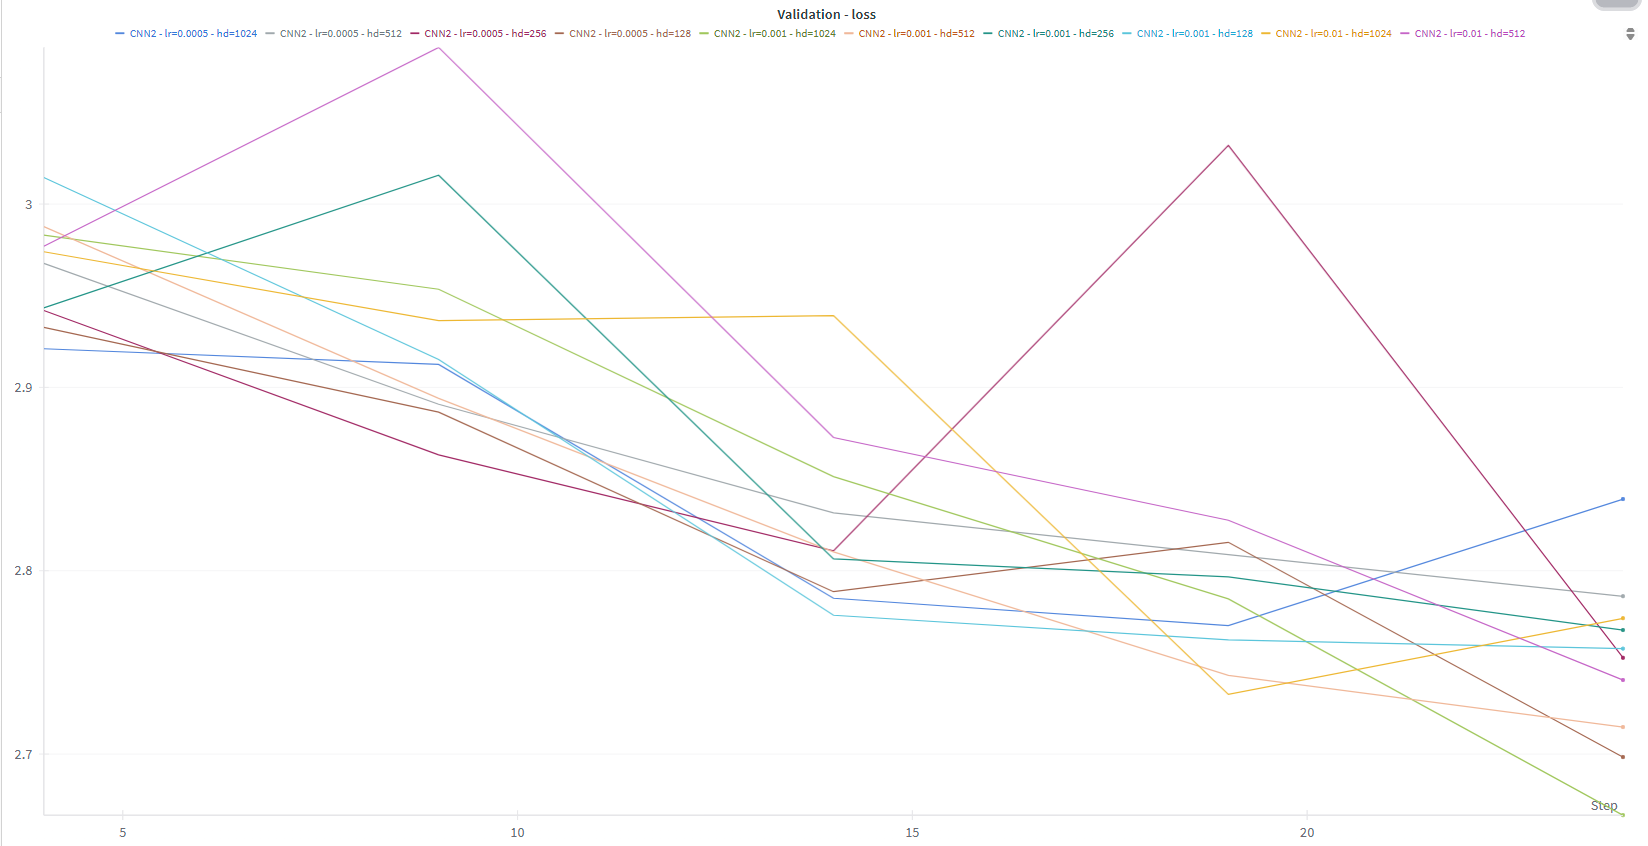

###LR, Hidden dim and batch size

####CNN1

In [ ]:
import copy

# Paramètres de base
base_lr = 1e-3
base_batch_size = 128
dropout = 0.1
epochs = 5

batch_sizes = [64, 128, 256]
lr_list = [base_lr, 5e-4]
hidden_dims = [128, 256, 512]

for bs in batch_sizes:
    # Création des DataLoaders
    train_loader = DataLoader(train_dataset_cnn1, batch_size=bs, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset_cnn1, batch_size=bs, shuffle=True, num_workers=2)

    for lr in lr_list:
        # Ajustement pour du scaling du learning rate
        lr_scaled = lr * (bs / base_batch_size)

        for dim_hidden in hidden_dims:
            run_cfg = copy.deepcopy(config)

            run_cfg['model_type'] = 'CNN1'
            run_cfg['batch_size'] = bs
            run_cfg['lr'] = lr_scaled
            run_cfg['dim_hidden'] = dim_hidden
            run_cfg['dropout'] = dropout
            run_cfg['epochs'] = epochs
            run_cfg['train_loader'] = train_loader
            run_cfg['val_loader'] = val_loader
            run_cfg['loss'] = nn.L1Loss()

            torch.manual_seed(run_cfg['seed'])
            model = CNN1(in_channels=1, dim_hidden=dim_hidden, dropout=dropout).to(run_cfg['device'])
            run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=lr_scaled)

            with wandb.init(
                config=run_cfg,
                project='LR, Hidden dim and batch size CNN1',
                group=f"CNN1 Grid - dropout = {dropout} - epochs = {epochs}",
                name=f"CNN1 - bs={bs} - lr={lr_scaled} - hidden={dim_hidden}",
                save_code=True,
            ):
                train_model(model, run_cfg)

            del model
            torch.cuda.empty_cache()


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.01
Eval -    loss: 10.69
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 33.48
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 29.05

Epoch 2
Train -   loss: 10.96
Eval -    loss: 11.34
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 26.76
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 9.23

Epoch 3
Train -   loss: 9.80
Eval -    loss: 9.57
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 40.57
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 18.70

Epoch 4
Train -   loss: 9.45
Eval -    loss: 9.11
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 19.45
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 25.27

Epoch 5
Train -   loss: 9.59
Eval -    loss: 8.99
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 27.52
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 25.96


Train - loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,▆█▃▁▁
Train - loss,9.59457
Validation - loss,8.99247


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.27
Eval -    loss: 10.92
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 55.39
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 43.43

Epoch 2
Train -   loss: 10.18
Eval -    loss: 9.86
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 54.86
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 22.95

Epoch 3
Train -   loss: 9.62
Eval -    loss: 9.32
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 21.62
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 39.98

Epoch 4
Train -   loss: 8.49
Eval -    loss: 9.01
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 8.01
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 51.09

Epoch 5
Train -   loss: 9.23
Eval -    loss: 8.83
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 27.79
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 25.28


Train - loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▃▂▁
Train - loss,9.23199
Validation - loss,8.82932


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.33
Eval -    loss: 10.63
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 37.15
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 36.26

Epoch 2
Train -   loss: 10.44
Eval -    loss: 9.80
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 69.00
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 15.12

Epoch 3
Train -   loss: 9.90
Eval -    loss: 9.28
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 19.08
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 38.49

Epoch 4
Train -   loss: 10.14
Eval -    loss: 10.09
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 21.17
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 44.10

Epoch 5
Train -   loss: 8.90
Eval -    loss: 8.50
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 33.11
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 26.72


Train - loss,█▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Validation - loss,█▅▄▆▁
Train - loss,8.90353
Validation - loss,8.50241


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.52
Eval -    loss: 11.77
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 36.60
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 35.90

Epoch 2
Train -   loss: 11.31
Eval -    loss: 10.49
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 30.13
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 15.92

Epoch 3
Train -   loss: 10.08
Eval -    loss: 9.94
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 44.30
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 16.49

Epoch 4
Train -   loss: 10.30
Eval -    loss: 9.72
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 18.95
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 25.08

Epoch 5
Train -   loss: 9.69
Eval -    loss: 9.39
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 33.67
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 25.53


Train - loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▃▂▁
Train - loss,9.69172
Validation - loss,9.39229


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.55
Eval -    loss: 11.31
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 49.71
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 42.65

Epoch 2
Train -   loss: 10.46
Eval -    loss: 11.10
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 55.65
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 19.77

Epoch 3
Train -   loss: 10.06
Eval -    loss: 10.14
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 24.68
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 40.94

Epoch 4
Train -   loss: 9.13
Eval -    loss: 9.40
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 8.74
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 50.39

Epoch 5
Train -   loss: 9.18
Eval -    loss: 9.30
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 28.99
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 23.48


Train - loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▇▄▁▁
Train - loss,9.1786
Validation - loss,9.30103


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.24
Eval -    loss: 11.22
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 42.25
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 42.80

Epoch 2
Train -   loss: 10.59
Eval -    loss: 10.38
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 60.68
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 15.55

Epoch 3
Train -   loss: 10.27
Eval -    loss: 9.72
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 17.66
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 40.79

Epoch 4
Train -   loss: 9.98
Eval -    loss: 9.34
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 20.23
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 39.78

Epoch 5
Train -   loss: 9.03
Eval -    loss: 9.34
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 33.87
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 31.64


Train - loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Validation - loss,█▅▂▁▁
Train - loss,9.03123
Validation - loss,9.33723


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.79
Eval -    loss: 13.01
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 40.37
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 40.93

Epoch 2
Train -   loss: 11.42
Eval -    loss: 10.61
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 34.34
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 19.98

Epoch 3
Train -   loss: 10.39
Eval -    loss: 10.12
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 36.24
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 15.02

Epoch 4
Train -   loss: 10.52
Eval -    loss: 9.75
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 16.99
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 21.31

Epoch 5
Train -   loss: 9.85
Eval -    loss: 9.19
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 28.30
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 26.67


Train - loss,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▃▂▁
Train - loss,9.84787
Validation - loss,9.18693


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.97
Eval -    loss: 11.87
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 48.87
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 45.46

Epoch 2
Train -   loss: 10.54
Eval -    loss: 10.60
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 56.25
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 20.53

Epoch 3
Train -   loss: 10.31
Eval -    loss: 9.72
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 22.36
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 43.33

Epoch 4
Train -   loss: 9.23
Eval -    loss: 9.21
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 5.29
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 47.56

Epoch 5
Train -   loss: 9.11
Eval -    loss: 9.08
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 26.68
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 25.92


Train - loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▃▁▁
Train - loss,9.10722
Validation - loss,9.07796


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.44
Eval -    loss: 11.35
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 41.93
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 39.80

Epoch 2
Train -   loss: 11.11
Eval -    loss: 10.30
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 62.10
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 20.57

Epoch 3
Train -   loss: 9.75
Eval -    loss: 9.25
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 22.10
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 34.53

Epoch 4
Train -   loss: 10.19
Eval -    loss: 10.17
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 27.09
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 41.13

Epoch 5
Train -   loss: 8.99
Eval -    loss: 8.54
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 30.52
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 30.16


Train - loss,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▃▅▁
Train - loss,8.98745
Validation - loss,8.544


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.71
Eval -    loss: 11.63
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 34.85
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 31.55

Epoch 2
Train -   loss: 11.39
Eval -    loss: 10.51
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 29.65
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 17.29

Epoch 3
Train -   loss: 10.35
Eval -    loss: 10.05
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 39.01
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 13.49

Epoch 4
Train -   loss: 11.14
Eval -    loss: 9.73
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 18.90
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 25.46

Epoch 5
Train -   loss: 9.48
Eval -    loss: 9.29
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 33.33
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 25.88


Train - loss,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▃▂▁
Train - loss,9.48332
Validation - loss,9.29499


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.42
Eval -    loss: 11.39
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 47.00
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 41.25

Epoch 2
Train -   loss: 10.49
Eval -    loss: 10.62
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 53.14
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 21.49

Epoch 3
Train -   loss: 10.53
Eval -    loss: 9.89
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 23.75
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 38.96

Epoch 4
Train -   loss: 9.48
Eval -    loss: 9.86
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 5.99
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 43.53

Epoch 5
Train -   loss: 9.25
Eval -    loss: 10.01
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 24.70
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 20.74


Train - loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▁▁▂
Train - loss,9.2504
Validation - loss,10.00954


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 11.92
Eval -    loss: 11.58
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 38.75
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 37.50

Epoch 2
Train -   loss: 10.77
Eval -    loss: 10.49
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 59.24
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 16.78

Epoch 3
Train -   loss: 9.95
Eval -    loss: 9.69
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 20.18
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 41.57

Epoch 4
Train -   loss: 10.19
Eval -    loss: 9.30
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 19.03
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 36.72

Epoch 5
Train -   loss: 9.66
Eval -    loss: 9.46
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 32.11
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 29.48


Train - loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▂▁▁
Train - loss,9.66237
Validation - loss,9.4554


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.78
Eval -    loss: 12.61
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 39.93
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 35.16

Epoch 2
Train -   loss: 11.86
Eval -    loss: 11.91
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 37.89
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 25.01

Epoch 3
Train -   loss: 11.35
Eval -    loss: 11.27
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 47.10
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 18.01

Epoch 4
Train -   loss: 10.73
Eval -    loss: 9.83
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 16.57
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 25.14

Epoch 5
Train -   loss: 10.00
Eval -    loss: 9.57
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 27.98
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 26.28


Train - loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Validation - loss,█▆▅▂▁
Train - loss,10.004
Validation - loss,9.57486


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 13.09
Eval -    loss: 12.59
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 41.41
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 37.74

Epoch 2
Train -   loss: 12.14
Eval -    loss: 11.41
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 49.50
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 24.08

Epoch 3
Train -   loss: 10.79
Eval -    loss: 10.35
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 20.56
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 40.05

Epoch 4
Train -   loss: 10.50
Eval -    loss: 9.98
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 6.38
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 41.10

Epoch 5
Train -   loss: 10.06
Eval -    loss: 10.53
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 24.84
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 18.73


Train - loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation - loss,█▅▂▁▂
Train - loss,10.05683
Validation - loss,10.52567


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.93
Eval -    loss: 12.55
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 46.65
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 45.95

Epoch 2
Train -   loss: 10.97
Eval -    loss: 10.58
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 60.99
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 14.68

Epoch 3
Train -   loss: 10.68
Eval -    loss: 9.92
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 18.06
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 34.13

Epoch 4
Train -   loss: 9.96
Eval -    loss: 9.60
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 17.10
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 38.41

Epoch 5
Train -   loss: 9.72
Eval -    loss: 9.44
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 31.71
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 26.37


Train - loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▂▁▁
Train - loss,9.72382
Validation - loss,9.43993


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.92
Eval -    loss: 12.50
CNN1 : Epoch 1 Train Prediction - Real age: 29.0, Predicted: 38.60
CNN1: Epoch 1 Val Prediction   - Real age: 40.0, Predicted: 34.19

Epoch 2
Train -   loss: 11.38
Eval -    loss: 11.10
CNN1 : Epoch 2 Train Prediction - Real age: 35.0, Predicted: 35.35
CNN1: Epoch 2 Val Prediction   - Real age: 2.0, Predicted: 23.38

Epoch 3
Train -   loss: 11.02
Eval -    loss: 10.31
CNN1 : Epoch 3 Train Prediction - Real age: 35.0, Predicted: 40.47
CNN1: Epoch 3 Val Prediction   - Real age: 25.0, Predicted: 16.07

Epoch 4
Train -   loss: 10.46
Eval -    loss: 10.14
CNN1 : Epoch 4 Train Prediction - Real age: 20.0, Predicted: 18.07
CNN1: Epoch 4 Val Prediction   - Real age: 19.0, Predicted: 26.25

Epoch 5
Train -   loss: 10.06
Eval -    loss: 10.10
CNN1 : Epoch 5 Train Prediction - Real age: 20.0, Predicted: 26.15
CNN1: Epoch 5 Val Prediction   - Real age: 23.0, Predicted: 20.33


Train - loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▄▂▁▁
Train - loss,10.06477
Validation - loss,10.10255


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 13.10
Eval -    loss: 12.56
CNN1 : Epoch 1 Train Prediction - Real age: 68.0, Predicted: 43.25
CNN1: Epoch 1 Val Prediction   - Real age: 43.0, Predicted: 42.00

Epoch 2
Train -   loss: 11.38
Eval -    loss: 12.28
CNN1 : Epoch 2 Train Prediction - Real age: 45.0, Predicted: 46.00
CNN1: Epoch 2 Val Prediction   - Real age: 26.0, Predicted: 19.07

Epoch 3
Train -   loss: 10.82
Eval -    loss: 10.46
CNN1 : Epoch 3 Train Prediction - Real age: 22.0, Predicted: 20.05
CNN1: Epoch 3 Val Prediction   - Real age: 34.0, Predicted: 38.12

Epoch 4
Train -   loss: 10.38
Eval -    loss: 11.28
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 3.86
CNN1: Epoch 4 Val Prediction   - Real age: 46.0, Predicted: 42.37

Epoch 5
Train -   loss: 9.91
Eval -    loss: 9.68
CNN1 : Epoch 5 Train Prediction - Real age: 24.0, Predicted: 26.34
CNN1: Epoch 5 Val Prediction   - Real age: 27.0, Predicted: 22.05


Train - loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁
Validation - loss,█▇▃▅▁
Train - loss,9.91348
Validation - loss,9.68112


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 12.55
Eval -    loss: 12.05
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 39.84
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 37.63

Epoch 2
Train -   loss: 10.97
Eval -    loss: 10.48
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 67.14
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 19.62

Epoch 3
Train -   loss: 10.81
Eval -    loss: 10.40
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 15.87
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 36.25

Epoch 4
Train -   loss: 10.11
Eval -    loss: 10.50
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 30.35
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 45.60

Epoch 5
Train -   loss: 9.44
Eval -    loss: 9.92
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 27.52
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 26.78


Train - loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation - loss,█▃▃▃▁
Train - loss,9.44035
Validation - loss,9.91934


##### Resultats
| Batch Size | Learning Rate | Hidden Dim | Train Loss | Val Loss |
|------------|----------------|------------|------------|----------|
| 64         | 0.0005         | 128        | 9.90       | 8.90     |
| 64         | 0.0005         | 256        | 9.30       | 9.15     |
| 64         | 0.0005         | 512        | 8.92       | **8.43** |
| 64         | 0.00025        | 128        | 9.97       | 9.63     |
| 64         | 0.00025        | 256        | 9.73       | 9.85     |
| 64         | 0.00025        | 512        | 9.23       | 9.13     |
| 128        | 0.001          | 128        | 9.42       | 9.05     |
| 128        | 0.001          | 256        | 9.69       | 8.62     |
| 128        | 0.001          | 512        | 9.21       | 10.58    |
| 128        | 0.0005         | 128        | 9.78       | 9.14     |
| 128        | 0.0005         | 256        | 10.07      | 9.95     |
| 128        | 0.0005         | 512        | 8.99       | 9.12     |
| 256        | 0.002          | 128        | 9.83       | 9.63     |
| 256        | 0.002          | 256        | 9.82       | 11.21    |
| 256        | 0.002          | 512        | 9.61       | 9.40     |
| 256        | 0.001          | 128        | 9.61       | 9.66     |
| 256        | 0.001          | 256        | 9.96       | 9.95     |
| 256        | 0.001          | 512        | 10.31      | 9.42     |


Le meilleur modèle CNN1 a été obtenu avec batch size = 64, learning rate = 0.0005 et hidden dim = 512, atteignant une validation loss minimale de 8.43.

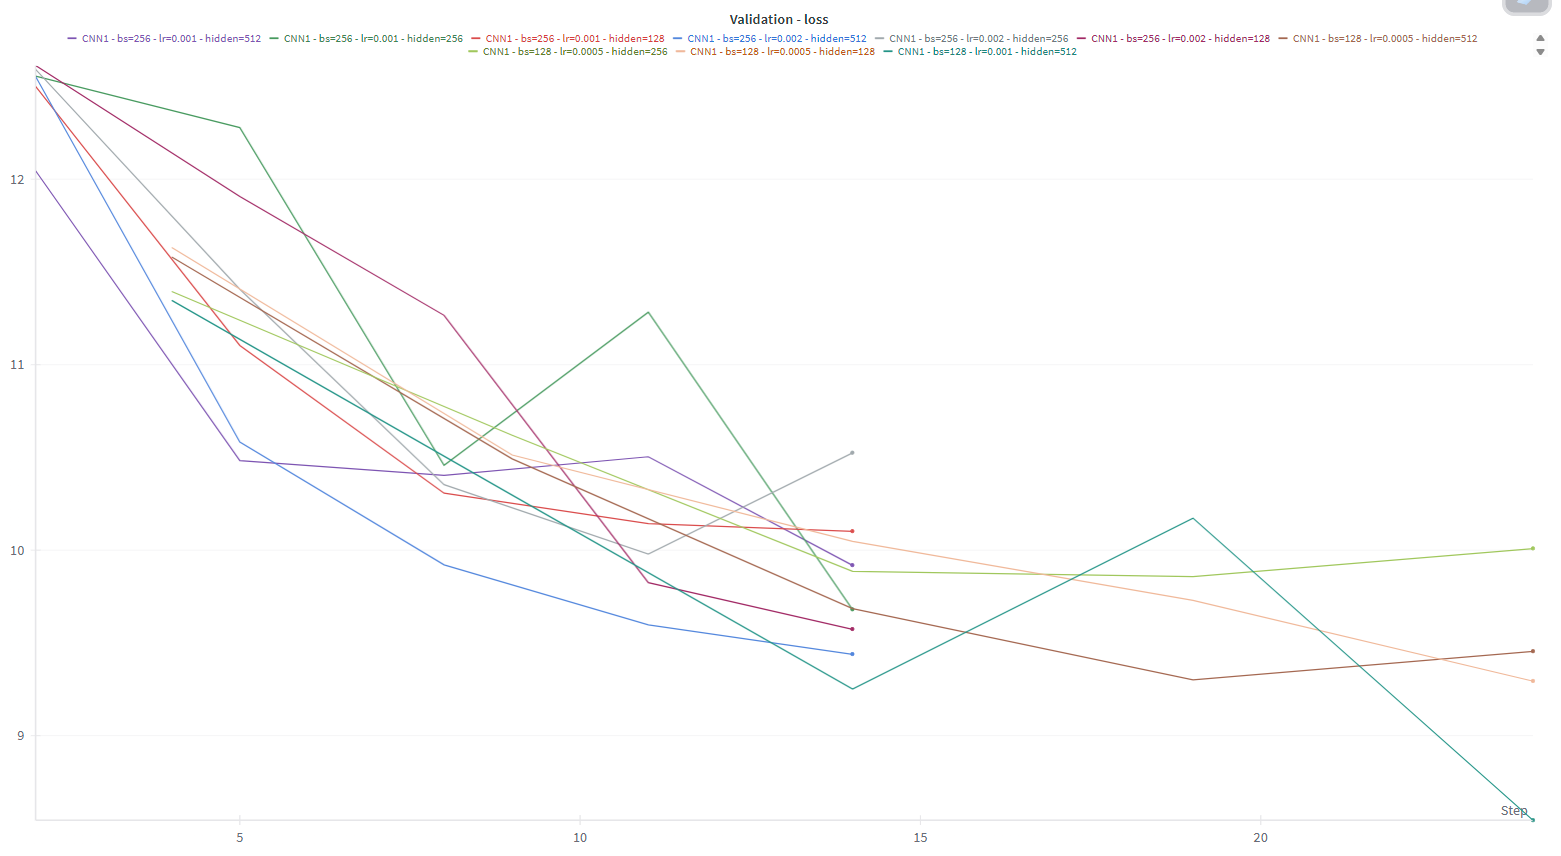

####CNN2

In [ ]:
import copy
base_lr = 1e-3
base_batch_size = 128
dropout = 0.1
epochs = 5

batch_sizes = [64, 128, 256]
lr_list = [base_lr, 5e-4]
hidden_dims = [128, 256, 512]

for bs in batch_sizes:
    train_loader = DataLoader(train_dataset_cnn2, batch_size=bs, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset_cnn2, batch_size=bs, shuffle=True, num_workers=2)

    for lr in lr_list:
        lr_scaled = lr * (bs / base_batch_size)

        for dim_hidden in hidden_dims:
            run_cfg = copy.deepcopy(config)

            run_cfg['model_type'] = 'CNN2'
            run_cfg['batch_size'] = bs
            run_cfg['lr'] = lr_scaled
            run_cfg['dim_hidden'] = dim_hidden
            run_cfg['dropout'] = dropout
            run_cfg['epochs'] = epochs
            run_cfg['train_loader'] = train_loader
            run_cfg['val_loader'] = val_loader
            run_cfg['loss'] = nn.CrossEntropyLoss()

            torch.manual_seed(run_cfg['seed'])
            model = CNN2(NUM_CLASSES, dim_hidden, dropout).to(run_cfg['device'])
            run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=lr_scaled)

            with wandb.init(
                config=run_cfg,
                project='CNN2 - LR, Hidden dim and batch size',
                group=f"CNN2 Grid - dropout = {dropout} - epochs = {epochs}",
                name=f"CNN2 - bs={bs} - lr={lr_scaled} - hidden={dim_hidden}",
                save_code=True,
            ):
                train_model(model, run_cfg)

            del model
            torch.cuda.empty_cache()


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.92
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1834
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1553

Epoch 2
Train -   loss: 2.90
Eval -    loss: 2.86
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 60, Likelihood: 0.0582
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1358

Epoch 3
Train -   loss: 2.79
Eval -    loss: 2.76
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3361
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 36, Likelihood: 0.0881

Epoch 4
Train -   loss: 2.80
Eval -    loss: 2.74
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1511
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 2, Likelihood: 0.4102

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.73
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted: 

Train - loss,█▆▅▅▄▄▄▄▃▃▄▄▃▃▄▄▃▃▃▃▃▃▃▃▁▃▃▃▃▃▃▃▁▂▂▃▂▂▂▂
Validation - loss,█▆▂▁▁
Train - loss,2.75536
Validation - loss,2.73301


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 3.12
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.1406
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.1127

Epoch 2
Train -   loss: 2.86
Eval -    loss: 3.06
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1190
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.4046

Epoch 3
Train -   loss: 2.83
Eval -    loss: 2.80
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 2, Likelihood: 0.4632
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.0672

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.80
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1251
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1684

Epoch 5
Train -   loss: 2.71
Eval -    loss: 2.89
CNN2: Epoch 5 Train Prediction - Real age: 18, Predicted

Train - loss,█▇▅▄▄▄▄▄▅▄▄▃▄▃▃▃▂▃▃▃▂▂▂▃▅▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁
Validation - loss,█▇▁▁▃
Train - loss,2.70512
Validation - loss,2.88842


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.91
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1330
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.2693

Epoch 2
Train -   loss: 2.91
Eval -    loss: 2.86
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.7115
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1900

Epoch 3
Train -   loss: 2.82
Eval -    loss: 2.76
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1487
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1221

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.75
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1510
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 24, Likelihood: 0.2030

Epoch 5
Train -   loss: 2.72
Eval -    loss: 2.76
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▆▅▅▅▄▄▄▃▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▁▃▃▃▃▃▂▂▄▃▃▂▂▃▂▂
Validation - loss,█▆▁▁▁
Train - loss,2.72381
Validation - loss,2.7581


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 2.94
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1873
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1697

Epoch 2
Train -   loss: 2.93
Eval -    loss: 2.90
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.0809
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1472

Epoch 3
Train -   loss: 2.83
Eval -    loss: 2.83
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2372
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 36, Likelihood: 0.1031

Epoch 4
Train -   loss: 2.84
Eval -    loss: 2.77
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1686
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 2, Likelihood: 0.2864

Epoch 5
Train -   loss: 2.79
Eval -    loss: 2.81
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted: 

Train - loss,█▇▅▅▄▄▄▄▃▃▄▄▃▃▄▃▄▃▃▃▃▃▃▃▁▂▃▂▃▃▂▃▂▂▂▂▂▂▂▂
Validation - loss,█▆▃▁▂
Train - loss,2.79389
Validation - loss,2.80728


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 3.00
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.1306
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.1186

Epoch 2
Train -   loss: 2.91
Eval -    loss: 2.96
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1334
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.3015

Epoch 3
Train -   loss: 2.87
Eval -    loss: 2.85
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 2, Likelihood: 0.4290
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 36, Likelihood: 0.0704

Epoch 4
Train -   loss: 2.80
Eval -    loss: 2.77
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 2, Likelihood: 0.1732
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1694

Epoch 5
Train -   loss: 2.75
Eval -    loss: 2.79
CNN2: Epoch 5 Train Prediction - Real age: 18, Predicted

Train - loss,█▇▆▅▄▄▄▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▅▃▃▂▃▃▃▂▁▂▂▂▂▂▂▂
Validation - loss,█▇▄▁▂
Train - loss,2.75163
Validation - loss,2.78501


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.95
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1179
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.2811

Epoch 2
Train -   loss: 2.93
Eval -    loss: 2.90
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.7008
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1871

Epoch 3
Train -   loss: 2.86
Eval -    loss: 2.81
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1988
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1782

Epoch 4
Train -   loss: 2.79
Eval -    loss: 2.80
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1731
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.2600

Epoch 5
Train -   loss: 2.77
Eval -    loss: 2.77
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▇▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▄▃▄▃▃▁▃▃▃▃▃▃▃▄▃▃▂▃▃▂▃
Validation - loss,█▆▂▂▁
Train - loss,2.7734
Validation - loss,2.77248


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.92
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2057
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1666

Epoch 2
Train -   loss: 2.90
Eval -    loss: 2.88
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.1059
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1604

Epoch 3
Train -   loss: 2.80
Eval -    loss: 2.79
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3814
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 54, Likelihood: 0.0812

Epoch 4
Train -   loss: 2.82
Eval -    loss: 2.79
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1377
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 26, Likelihood: 0.0782

Epoch 5
Train -   loss: 2.75
Eval -    loss: 2.78
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted:

Train - loss,█▅▄▄▃▃▃▃▃▃▂▃▂▂▂▁▂▂▂▂▂▂▂▂▂
Validation - loss,█▆▁▁▁
Train - loss,2.74774
Validation - loss,2.78222


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.93
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.1595
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.1831

Epoch 2
Train -   loss: 2.85
Eval -    loss: 3.15
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 60, Likelihood: 0.0607
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2996

Epoch 3
Train -   loss: 2.84
Eval -    loss: 2.84
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 2, Likelihood: 0.3321
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.0767

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.76
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1554
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1625

Epoch 5
Train -   loss: 2.73
Eval -    loss: 3.01
CNN2: Epoch 5 Train Prediction - Real age: 18, Predicted

Train - loss,█▅▄▄▃▅▃▃▃▂▂▃▂▂▂▃▂▂▂▁▁▁▁▁▁
Validation - loss,▄█▃▁▆
Train - loss,2.72652
Validation - loss,3.01238


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.93
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1314
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.3476

Epoch 2
Train -   loss: 2.95
Eval -    loss: 2.90
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.7782
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1631

Epoch 3
Train -   loss: 2.84
Eval -    loss: 2.78
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.2110
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1401

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.91
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1298
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.2391

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.74
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▅▄▃▃▃▃▃▂▃▃▂▂▂▂▁▂▂▂▁▂▁▁▁▁
Validation - loss,█▇▂▇▁
Train - loss,2.76361
Validation - loss,2.74446


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.94
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1807
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1740

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.91
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.0984
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.1519

Epoch 3
Train -   loss: 2.82
Eval -    loss: 2.80
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3470
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 36, Likelihood: 0.0789

Epoch 4
Train -   loss: 2.84
Eval -    loss: 2.83
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1650
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 26, Likelihood: 0.0684

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.79
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted:

Train - loss,█▆▄▄▄▃▃▃▃▃▂▃▂▂▂▁▂▂▂▂▂▂▂▁▂
Validation - loss,█▆▁▃▁
Train - loss,2.7574
Validation - loss,2.78577


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 2.95
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.1742
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.1827

Epoch 2
Train -   loss: 2.90
Eval -    loss: 2.94
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1260
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2802

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.82
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 2, Likelihood: 0.3645
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 54, Likelihood: 0.0778

Epoch 4
Train -   loss: 2.77
Eval -    loss: 2.77
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1381
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1983

Epoch 5
Train -   loss: 2.74
Eval -    loss: 2.89
CNN2: Epoch 5 Train Prediction - Real age: 18, Predicte

Train - loss,█▆▄▄▃▆▃▃▃▃▂▃▂▂▂▃▂▂▂▁▁▂▁▁▁
Validation - loss,█▇▃▁▅
Train - loss,2.736
Validation - loss,2.88795


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 3.01
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1437
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.4127

Epoch 2
Train -   loss: 2.97
Eval -    loss: 2.96
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.8174
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1460

Epoch 3
Train -   loss: 2.86
Eval -    loss: 2.80
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1884
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1408

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.82
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1856
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.3066

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.81
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▅▄▃▃▃▃▃▂▃▃▂▂▂▂▁▂▂▂▁▂▁▁▁▁
Validation - loss,█▆▁▂▁
Train - loss,2.76035
Validation - loss,2.80903


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.95
Eval -    loss: 2.92
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2326
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.2164

Epoch 2
Train -   loss: 2.90
Eval -    loss: 2.92
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 36, Likelihood: 0.0847
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.2225

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.89
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3027
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 54, Likelihood: 0.1036

Epoch 4
Train -   loss: 2.84
Eval -    loss: 2.80
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1282
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 2, Likelihood: 0.2362

Epoch 5
Train -   loss: 2.75
Eval -    loss: 2.74
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted: 

Train - loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁
Validation - loss,██▇▃▁
Train - loss,2.75205
Validation - loss,2.74018


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.98
Eval -    loss: 2.95
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.2296
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.2590

Epoch 2
Train -   loss: 2.91
Eval -    loss: 2.89
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 36, Likelihood: 0.0922
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2601

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.89
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 26, Likelihood: 0.1856
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 26, Likelihood: 0.0868

Epoch 4
Train -   loss: 2.81
Eval -    loss: 2.90
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2951
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.2394

Epoch 5
Train -   loss: 2.77
Eval -    loss: 2.88
CNN2: Epoch 5 Train Prediction - Real age: 18, Predict

Train - loss,█▄▃▅▃▂▁▂▂▂▂▁▂▁▁
Validation - loss,█▂▂▃▁
Train - loss,2.76608
Validation - loss,2.88053


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.97
Eval -    loss: 2.96
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.1080
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.2811

Epoch 2
Train -   loss: 2.91
Eval -    loss: 2.93
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2686
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1649

Epoch 3
Train -   loss: 2.84
Eval -    loss: 2.84
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1367
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.0956

Epoch 4
Train -   loss: 2.79
Eval -    loss: 2.83
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2082
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.2765

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.74
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▄▃▃▃▃▃▂▂▂▂▁▂▁▁
Validation - loss,█▇▄▄▁
Train - loss,2.7634
Validation - loss,2.74023


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.93
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2210
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1990

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.91
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.1151
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.2246

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.82
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.4573
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 36, Likelihood: 0.0697

Epoch 4
Train -   loss: 2.85
Eval -    loss: 2.80
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1451
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 2, Likelihood: 0.1162

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.71
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted: 

Train - loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁
Validation - loss,█▇▄▄▁
Train - loss,2.76221
Validation - loss,2.71399


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.00
Eval -    loss: 3.01
CNN2: Epoch 1 Train Prediction - Real age: 8, Predicted: 26, Likelihood: 0.1970
CNN2: Epoch 1 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.1848

Epoch 2
Train -   loss: 2.93
Eval -    loss: 2.90
CNN2: Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1528
CNN2: Epoch 2 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.2519

Epoch 3
Train -   loss: 2.87
Eval -    loss: 2.95
CNN2: Epoch 3 Train Prediction - Real age: 38, Predicted: 26, Likelihood: 0.1262
CNN2: Epoch 3 Val Prediction   - Real age: 56, Predicted: 60, Likelihood: 0.0759

Epoch 4
Train -   loss: 2.82
Eval -    loss: 2.81
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1998
CNN2: Epoch 4 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.2165

Epoch 5
Train -   loss: 2.78
Eval -    loss: 2.86
CNN2: Epoch 5 Train Prediction - Real age: 18, Predict

Train - loss,█▅▃▄▃▃▁▂▂▂▂▁▁▁▁
Validation - loss,█▄▆▁▃
Train - loss,2.77701
Validation - loss,2.85676


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.98
Eval -    loss: 2.97
CNN2: Epoch 1 Train Prediction - Real age: 14, Predicted: 26, Likelihood: 0.0987
CNN2: Epoch 1 Val Prediction   - Real age: 56, Predicted: 2, Likelihood: 0.1958

Epoch 2
Train -   loss: 2.93
Eval -    loss: 2.88
CNN2: Epoch 2 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.6054
CNN2: Epoch 2 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1940

Epoch 3
Train -   loss: 2.87
Eval -    loss: 2.89
CNN2: Epoch 3 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1388
CNN2: Epoch 3 Val Prediction   - Real age: 36, Predicted: 26, Likelihood: 0.1135

Epoch 4
Train -   loss: 2.80
Eval -    loss: 2.88
CNN2: Epoch 4 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.1807
CNN2: Epoch 4 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.2717

Epoch 5
Train -   loss: 2.79
Eval -    loss: 2.85
CNN2: Epoch 5 Train Prediction - Real age: 86, Predicted

Train - loss,█▅▃▃▃▃▃▂▂▁▂▁▂▁▁
Validation - loss,█▃▃▃▁
Train - loss,2.78736
Validation - loss,2.84768


##### Resultat

|   Batch Size |   Learning Rate |   Hidden Dim |   Train Loss |   Val Loss |
|-------------:|----------------:|-------------:|-------------:|-----------:|
|           64 |         0.0005  |          128 |      2.75536 |    2.73301 |
|           64 |         0.0005  |          256 |      2.70512 |    2.88842 |
|           64 |         0.0005  |          512 |      2.72381 |    2.75810 |
|           64 |         0.00025 |          128 |      2.79389 |    2.80728 |
|           64 |         0.00025 |          256 |      2.75163 |    2.78501 |
|           64 |         0.00025 |          512 |      2.77340 |    2.77248 |
|          128 |         0.001   |          128 |      2.74774 |    2.78222 |
|          128 |         0.001   |          256 |      2.72652 |    3.01238 |
|          128 |         0.001   |          512 |      2.76361 |    2.74446 |
|          128 |         0.0005  |          128 |      2.75740 |    2.78577 |
|          128 |         0.0005  |          256 |      2.73600 |    2.88795 |
|          128 |         0.0005  |          512 |      2.76035 |    2.80903 |
|          256 |         0.002   |          128 |      2.75205 |    2.74018 |
|          256 |         0.002   |          256 |      2.76608 |    2.88053 |
|          256 |         0.002   |          512 |      2.76340 |    2.74023 |
|          256 |         0.001   |          128 |      2.76221 |    2.71399 |
|          256 |         0.001   |          256 |      2.77701 |    2.85676 |
|          256 |         0.001   |          512 |      2.78736 |    2.84768 |


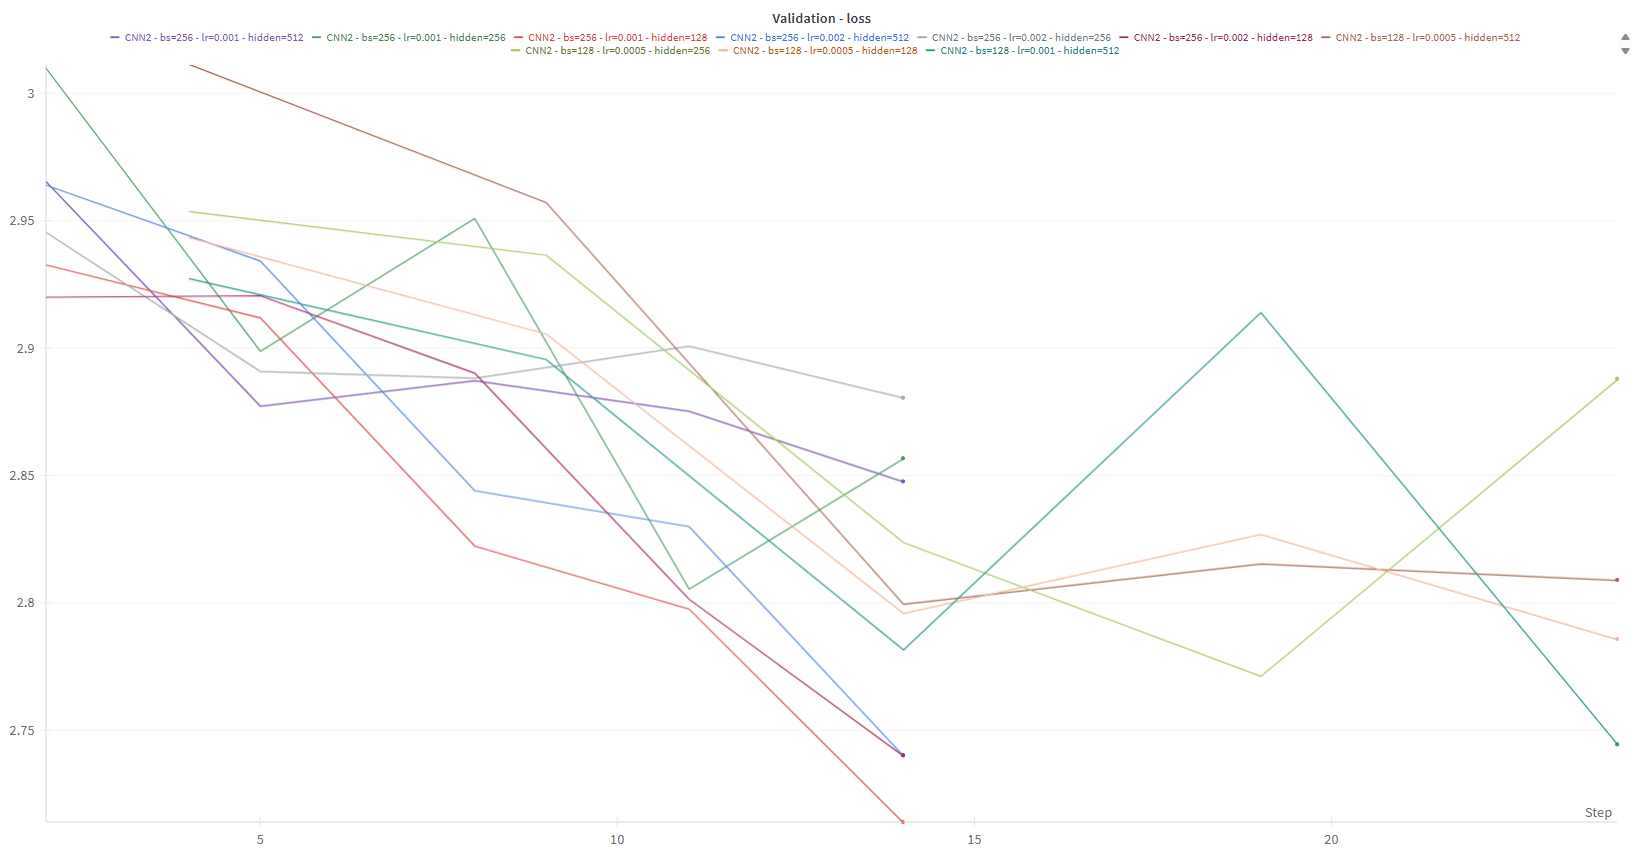

la meilleure performance a été obtenue avec une taille de lot (batch size) de 256, un taux d’apprentissage (learning rate) de 0.001 et une dimension cachée (hidden dim) de 128.

## Final Training

####CNN1

In [ ]:
# Configuration finale recommandée pour CNN1 (selon les résultats du grid search)
config = {
    'epochs': 70,                      # Nombre d'époques augmenté pour convergence
    'batch_size': 64,                 # Meilleur batch size observé
    'lr': 0.0005,                     # Meilleur taux d'apprentissage observé
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'clip': 5,
    'dim_hidden': 512,               # Meilleur hidden dim observé
    'dropout': 0.1,                  # Stable
    'model_type': 'CNN1',
    'seed': 0,
    'log_every': 50,
    'in_channels': 1
}

torch.manual_seed(config['seed'])

# Chargement des dataloaders
config['train_loader'] = DataLoader(train_dataset_cnn1, batch_size=config['batch_size'], shuffle=True, num_workers=2)
config['val_loader'] = DataLoader(val_dataset_cnn1, batch_size=config['batch_size'], shuffle=True, num_workers=2)

# Modèle
model = CNN1(
    in_channels=config['in_channels'],
    dim_hidden=config['dim_hidden'],
    dropout=config['dropout']
).to(config['device'])

# Optimiseur et fonction de perte
config['optimizer'] = torch.optim.Adam(model.parameters(), lr=config['lr'])
config['loss'] = nn.L1Loss()

# Entraînement final avec wandb
with wandb.init(
    config=config,
    project='CNN1 Final Training',
    name=f"CNN1 - Final - bs={config['batch_size']} - dim={config['dim_hidden']} - lr={config['lr']} - epochs={config['epochs']}",
    group="CNN1 - final",
    save_code=True,
):
    train_model(model, config)


Starting training for 70 epochs, using cuda.

Epoch 1
Train -   loss: 10.87
Eval -    loss: 10.64
CNN1 : Epoch 1 Train Prediction - Real age: 24.0, Predicted: 43.09
CNN1: Epoch 1 Val Prediction   - Real age: 26.0, Predicted: 45.31

Epoch 2
Train -   loss: 10.54
Eval -    loss: 9.89
CNN1 : Epoch 2 Train Prediction - Real age: 65.0, Predicted: 62.75
CNN1: Epoch 2 Val Prediction   - Real age: 4.0, Predicted: 16.81

Epoch 3
Train -   loss: 9.74
Eval -    loss: 9.36
CNN1 : Epoch 3 Train Prediction - Real age: 24.0, Predicted: 19.43
CNN1: Epoch 3 Val Prediction   - Real age: 43.0, Predicted: 36.54

Epoch 4
Train -   loss: 9.70
Eval -    loss: 8.84
CNN1 : Epoch 4 Train Prediction - Real age: 2.0, Predicted: 19.68
CNN1: Epoch 4 Val Prediction   - Real age: 53.0, Predicted: 35.64

Epoch 5
Train -   loss: 8.62
Eval -    loss: 8.45
CNN1 : Epoch 5 Train Prediction - Real age: 26.0, Predicted: 32.76
CNN1: Epoch 5 Val Prediction   - Real age: 26.0, Predicted: 28.19

Epoch 6
Train -   loss: 8.50
Eval

Train - loss,█▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▄▃▃▃▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁
Validation - loss,█▆▅▄▄▃▃▂▂▃▂▁▁▁▂▁▁▁▁▂▁▂▁▂▁▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁
Train - loss,2.21776
Validation - loss,7.27474


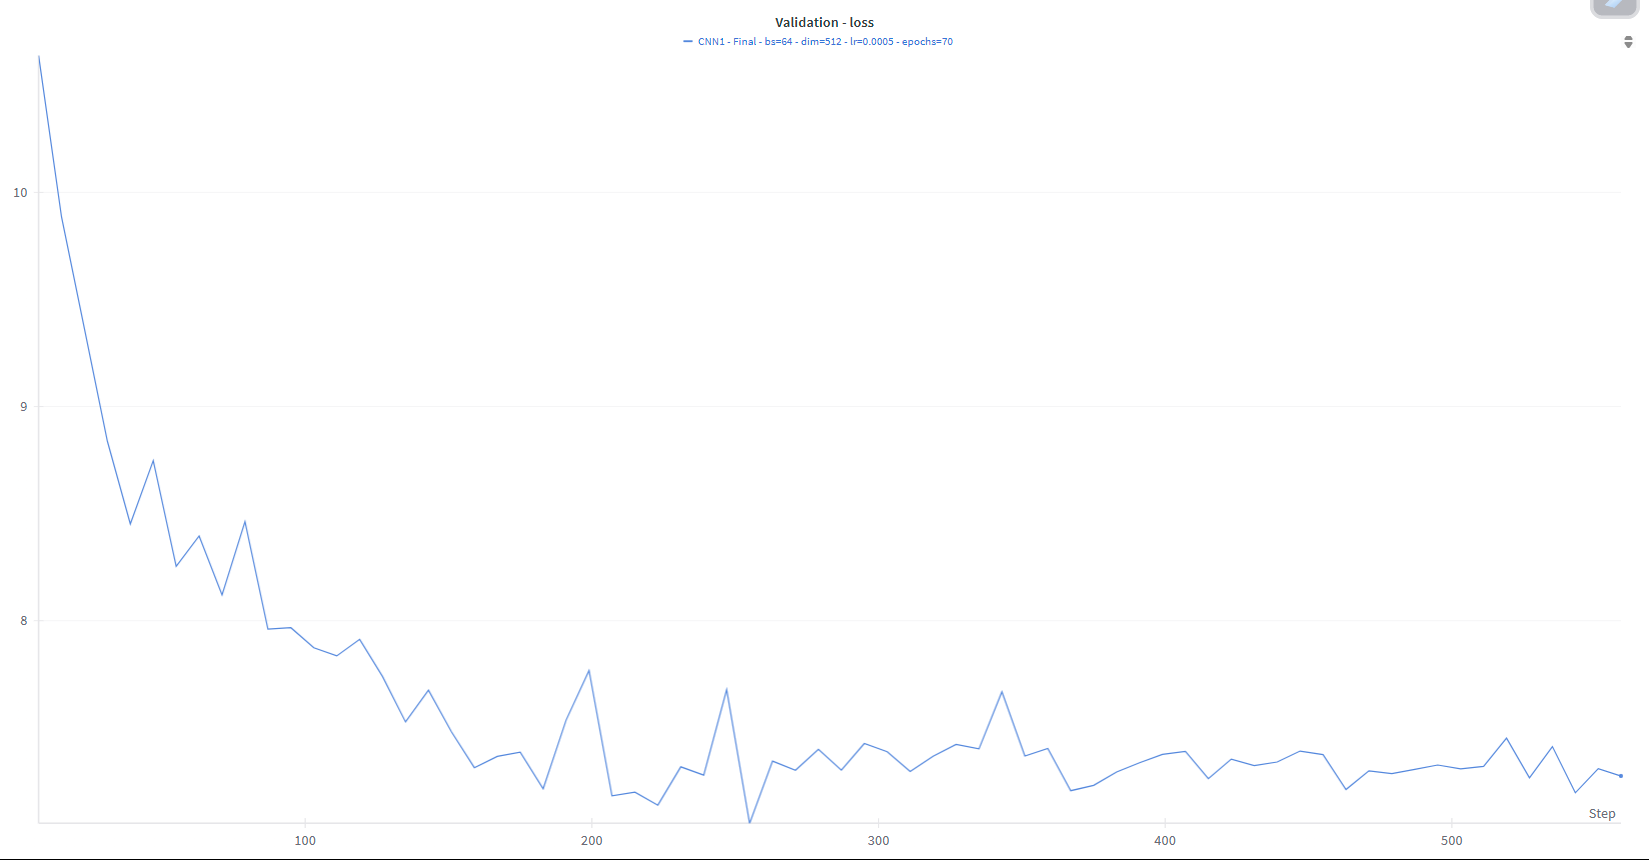

Le modèle CNN1 avec bs=64, dim=512, lr=0.0005 et epochs=70 mémorise trop bien les données d'entraînement mais généralise mal sur de nouvelles données. Cela signifie qu'il a appris à reproduire les exemples du dataset d'entraînement sans bien capter les tendances générales du problème.


Train - loss	`2.21776` ||
Validation - loss	`7.27474`


####CNN2

In [ ]:
# Configuration finale pour CNN2 - Meilleur modèle trouvé
config = {
    'epochs': 50,
    'batch_size': 256,              # Meilleur batch size
    'lr': 0.001,                    # Meilleur learning rate
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'clip': 5,
    'dim_hidden': 128,             # Meilleure dimension cachée
    'dropout': 0.1,
    'model_type': 'CNN2',
    'seed': 0,
    'log_every': 50,
    'num_classes': 30
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(train_dataset_cnn2, batch_size=config['batch_size'], shuffle=True, num_workers=2)
config['val_loader'] = DataLoader(val_dataset_cnn2, batch_size=config['batch_size'], shuffle=True, num_workers=2)

model = CNN2(
    age_classes=config['num_classes'],
    hidden_dim=config['dim_hidden'],
    dropout=config['dropout']
).to(config['device'])

config['optimizer'] = torch.optim.Adam(model.parameters(), lr=config['lr'])
config['loss'] = nn.CrossEntropyLoss()

with wandb.init(
    config=config,
    project='CNN2 Final Training',
    name=f"CNN2 - Final - bs={config['batch_size']} - dim={config['dim_hidden']} - lr={config['lr']} - epochs={config['epochs']}",
    group="CNN2 - final",
    save_code=True,
):
    train_model(model, config)


Starting training for 50 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.94
CNN2: Epoch 1 Train Prediction - Real age: 36, Predicted: 26, Likelihood: 0.2154
CNN2: Epoch 1 Val Prediction   - Real age: 20, Predicted: 26, Likelihood: 0.1917

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.93
CNN2: Epoch 2 Train Prediction - Real age: 44, Predicted: 26, Likelihood: 0.1218
CNN2: Epoch 2 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.2334

Epoch 3
Train -   loss: 2.86
Eval -    loss: 2.82
CNN2: Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.4643
CNN2: Epoch 3 Val Prediction   - Real age: 54, Predicted: 36, Likelihood: 0.0852

Epoch 4
Train -   loss: 2.85
Eval -    loss: 2.77
CNN2: Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1415
CNN2: Epoch 4 Val Prediction   - Real age: 8, Predicted: 2, Likelihood: 0.1564

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.72
CNN2: Epoch 5 Train Prediction - Real age: 8, Predicted:

Train - loss,█▆▆▆▅▅▄▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▃▂▂▂▁▁▁▁▁▂▁▁▁▁
Validation - loss,▆▆▄▄▃▅▇▃▃▃▆▃▄▃▃▂█▃▄▂▃▂▁▄▃▆▁▁
Train - loss,2.49902
Validation - loss,2.50491


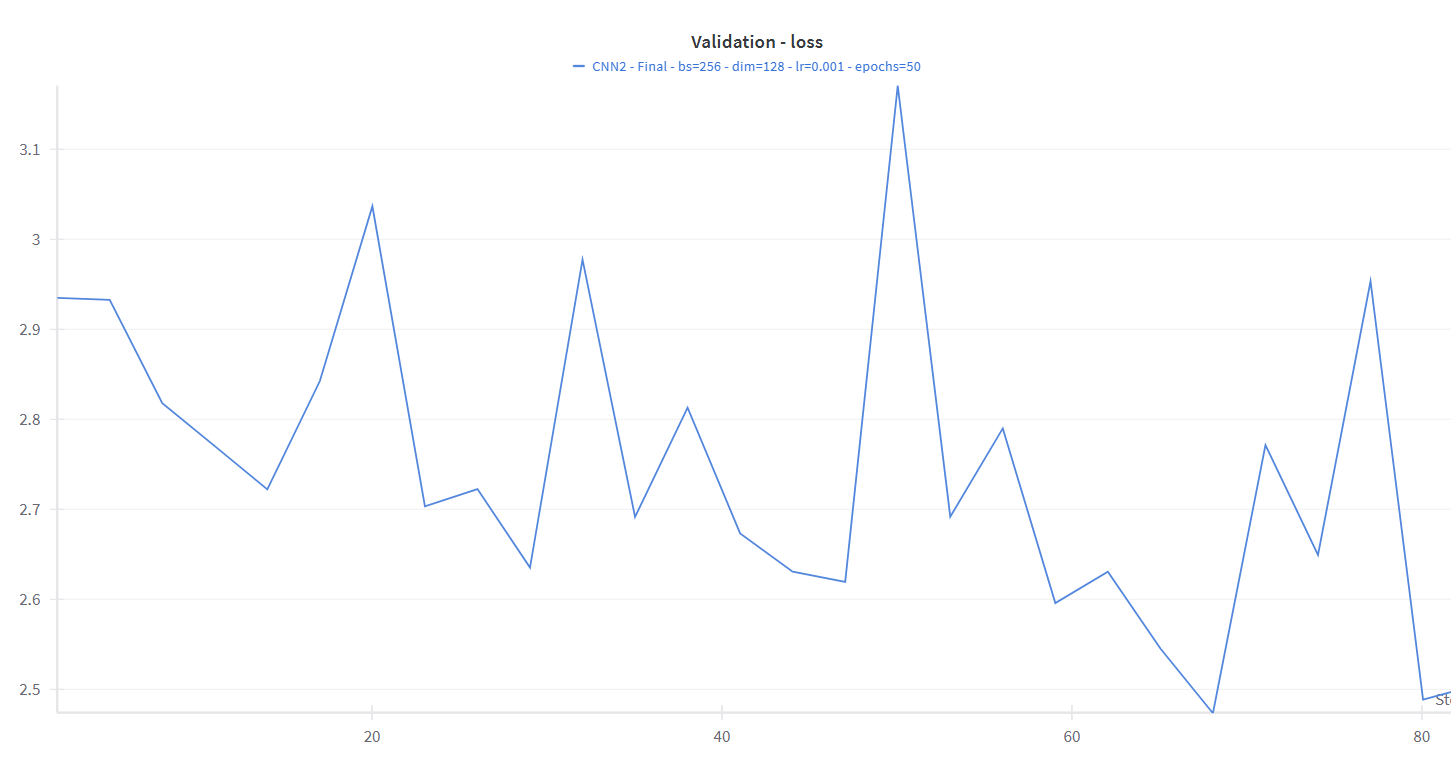

Le modèle CNN2 final a été entraîné efficacement, atteignant une perte d'entraînement de 2.499 et une perte de validation de 2.505 après 29 époques. La faible différence entre les deux pertes montre que le modèle généralise bien aux données non vues. L'utilisation d'un batch_size=256, hidden_dim=128 et lr=0.001 a permis d'atteindre une convergence stable sans overfitting.

Train - loss	`	2.49902` ||
Validation - loss	`2.50491`
